In [ ]:
pip install fedot==0.4.1

In [ ]:
# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

from sklearn.metrics import mean_absolute_error

import warnings

from fedot.core.data.multi_modal import MultiModalData

In [ ]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
import scipy.stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

from scipy.ndimage import gaussian_filter
from statsmodels.graphics.gofplots import qqplot

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams.update({'font.size': 18})
plt.style.use(['seaborn-white', 'seaborn-bright'])

In [ ]:
df = pd.read_csv('lunar_time.csv')

df.head(2)

,Catalog Number,Calendar Date,Eclipse Time,Delta T (s),Lunation Number,Saros Number,Eclipse Type,Quincena Solar Eclipse,Gamma,Penumbral Magnitude,Umbral Magnitude,Latitude,Longitude,Penumbral Eclipse Duration (m),Partial Eclipse Duration (m),Total Eclipse Duration (m),Time JD,Longitude W,Longitude E,Latitude S,Latitude N
0,1,-1999 June 26,14:13:28,46437,-49456,17,0,9,-1.0981,0.8791,-0.1922,24S,22W,268.8,0.0,0.0,991100.092685,22.0,0.0,24.0,0.0
1,2,-1999 November 21,20:23:49,46427,-49451,-16,0,0,-1.1155,0.8143,-0.1921,15N,98W,233.4,0.0,0.0,991248.349873,98.0,0.0,0.0,15.0


In [ ]:
cols = ['Partial Eclipse Duration (m)','Penumbral Eclipse Duration (m)', 'Penumbral Magnitude', 'Umbral Magnitude']
data = df[cols]

N = 183

# анализ стационарности

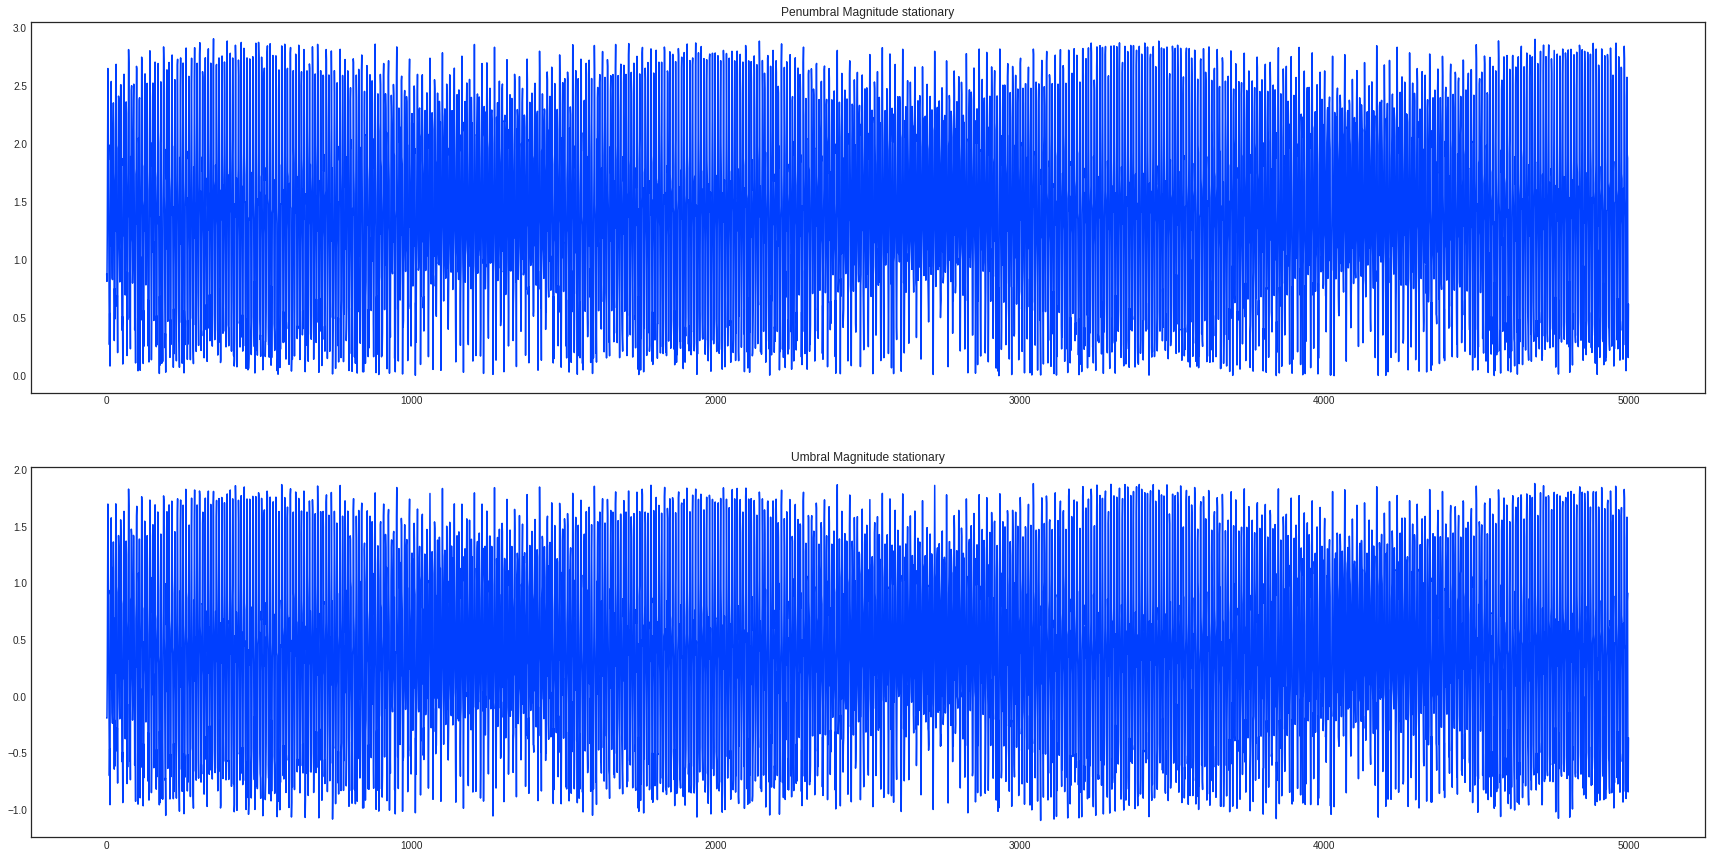

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(30, 15))
for en, i in enumerate(ax):
    i.plot(data[cols[en+2]][:5000])
    test = sm.tsa.adfuller(data[cols[en+2]])
    stat = ' not stationary' if test[0]> test[4]['5%'] else ' stationary'
    i.set_title(cols[en+2]+stat)

# автоковариация и mutual covariance

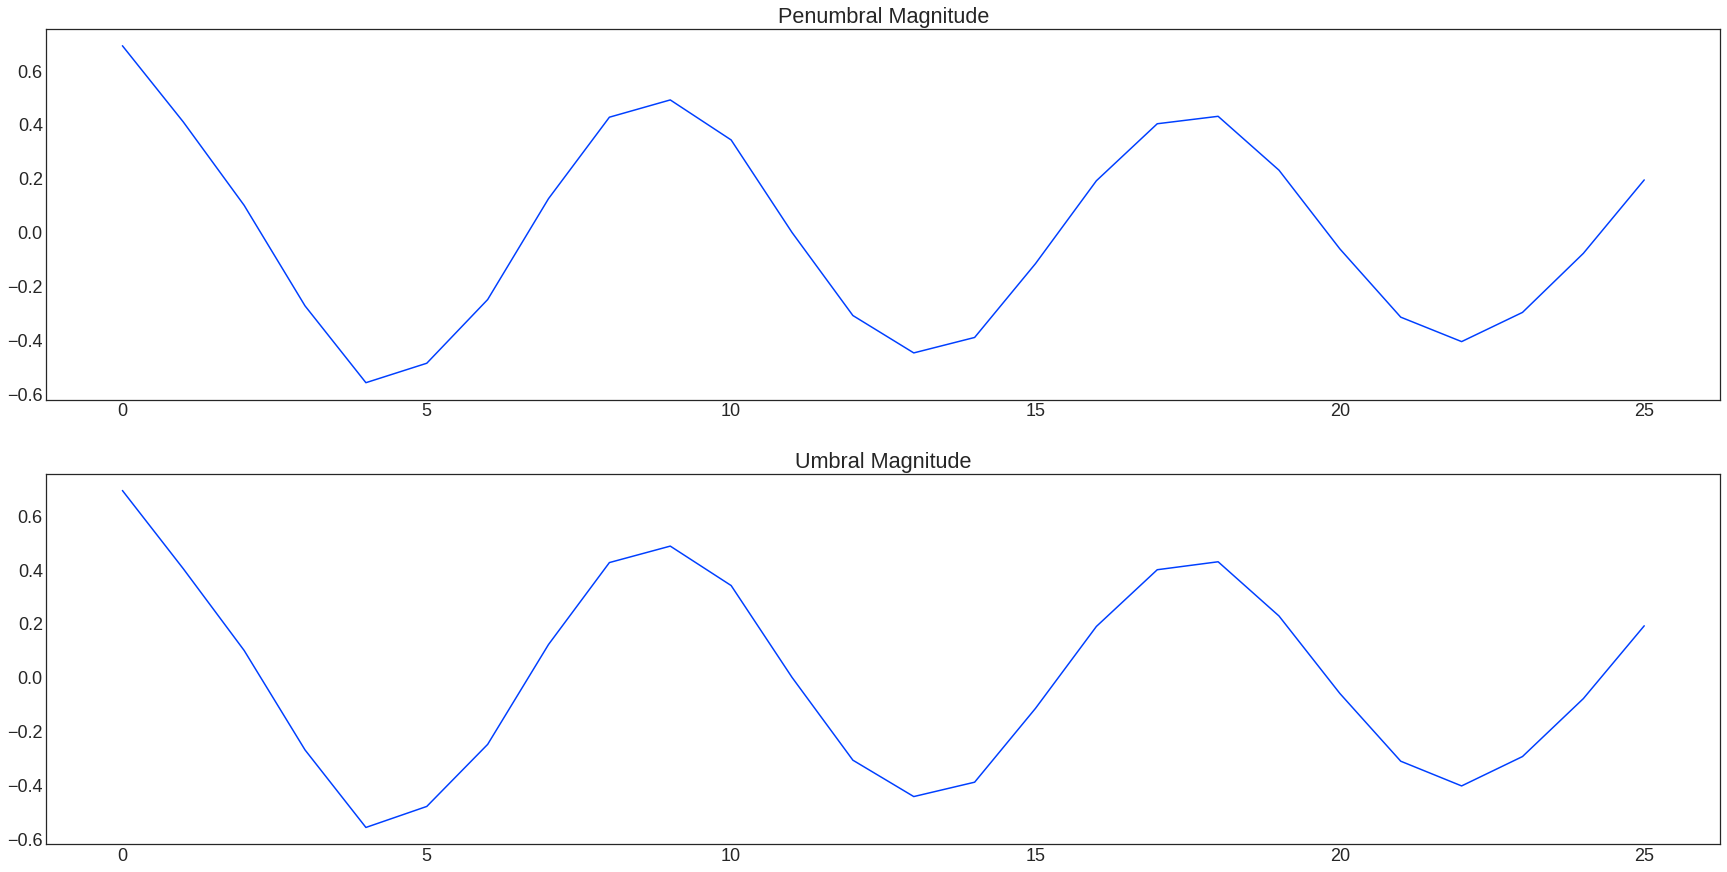

In [ ]:

fig, ax = plt.subplots(2, 1, figsize=(30, 15))
for en, i in enumerate(ax):
    i.plot(stattools.acovf(data[cols[en+2]], fft=True, nlag=25))
    i.set_title(cols[en+2])

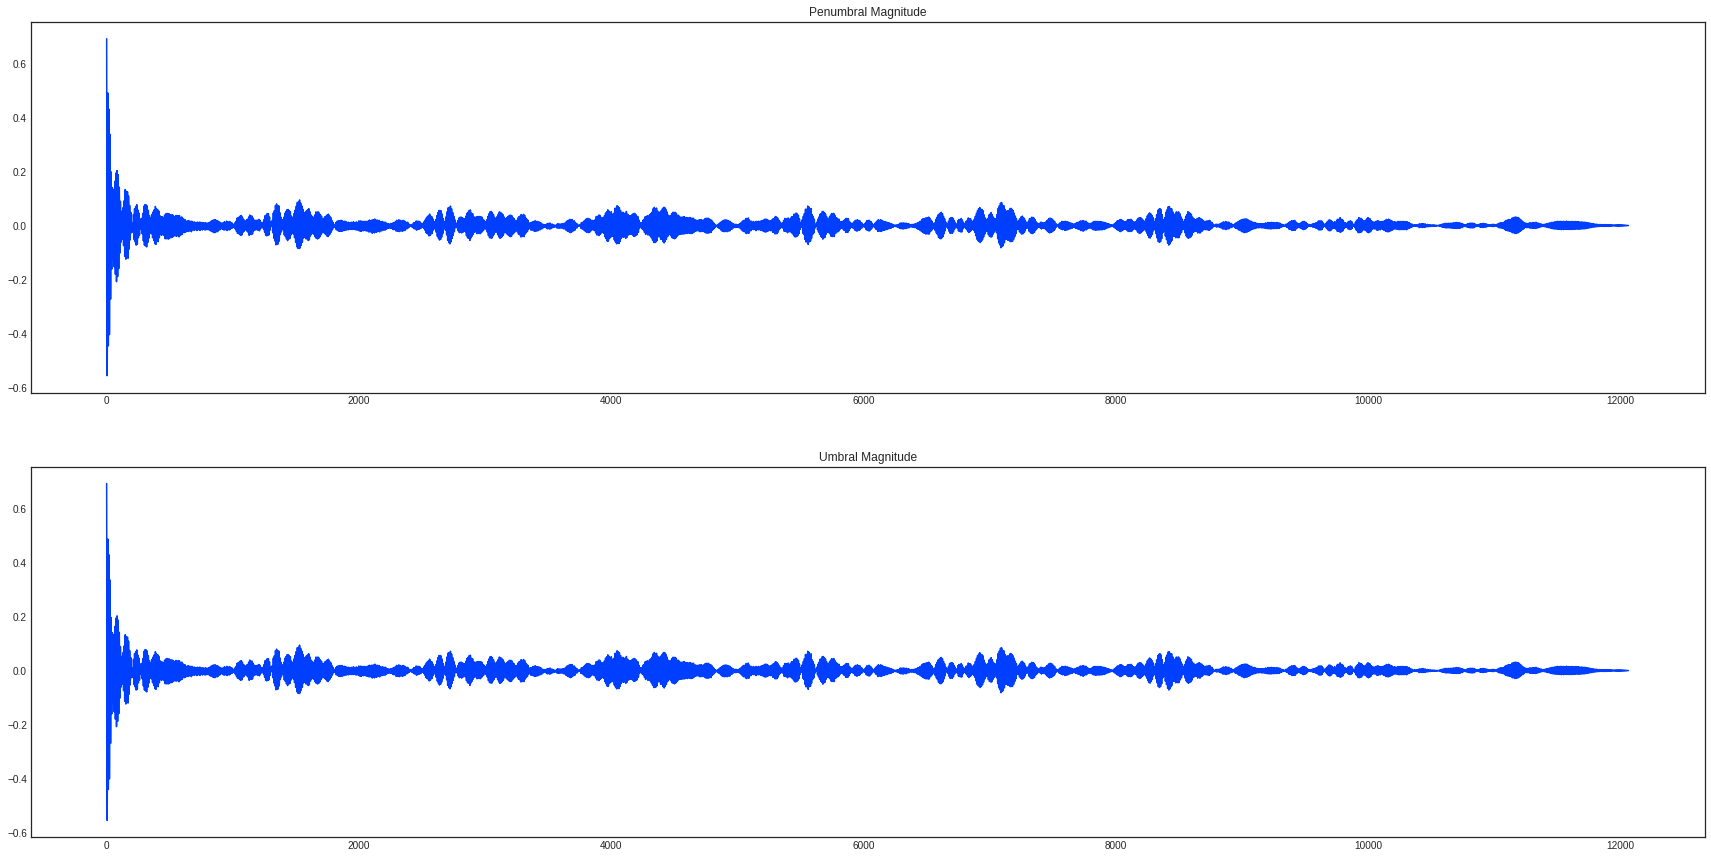

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(30, 15))
for en, i in enumerate(ax):
    i.plot(stattools.acovf(data[cols[en+2]], fft=True))
    i.set_title(cols[en+2])

In [ ]:
pred_pen = data[cols[2]].rolling(1).mean()
pred_um = data[cols[2]].rolling(1).mean()

In [ ]:
vart_1_pen = data[cols[2]].values
vart_pen = data[cols[2]].shift(1).fillna(1.41).values
predt_1_pen = pred_pen.values
predt_pen = pred_pen.shift(1).fillna(1.41).values

vart_1_um = data[cols[3]].values
vart_um = data[cols[3]].shift(1).fillna(0.40).values
predt_1_um = pred_um.values
predt_um = pred_um.shift(1).fillna(0.40).values

In [ ]:
mutualcorr_pen = pd.DataFrame({'Var t-1':vart_1_pen, 'Var t':vart_pen, 'Pred t-1':predt_1_pen, 'Pred t':predt_pen}, index=data.index)
mutualcorr_um = pd.DataFrame({'Var t-1':vart_1_um, 'Var t':vart_um, 'Pred t-1':predt_1_um, 'Pred t':predt_um}, index=data.index)


Text(0.5, 1.0, 'Umbral Magnitude Mutual corr')

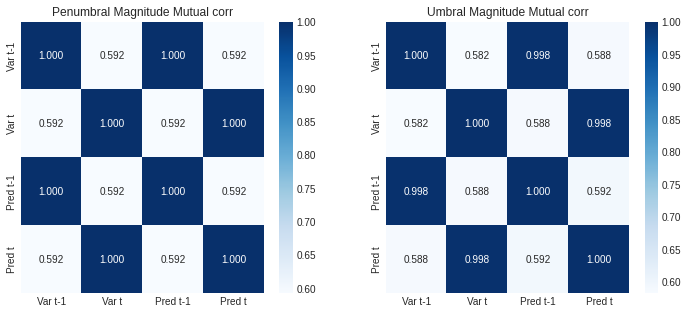

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(mutualcorr_pen.corr(), annot=True, fmt= '.3f', ax = ax[0], cmap = 'Blues')
ax[0].set_title('Penumbral Magnitude Mutual corr')

sns.heatmap(mutualcorr_um.corr(), annot=True, fmt= '.3f', ax = ax[1], cmap = 'Blues')
ax[1].set_title('Umbral Magnitude Mutual corr')

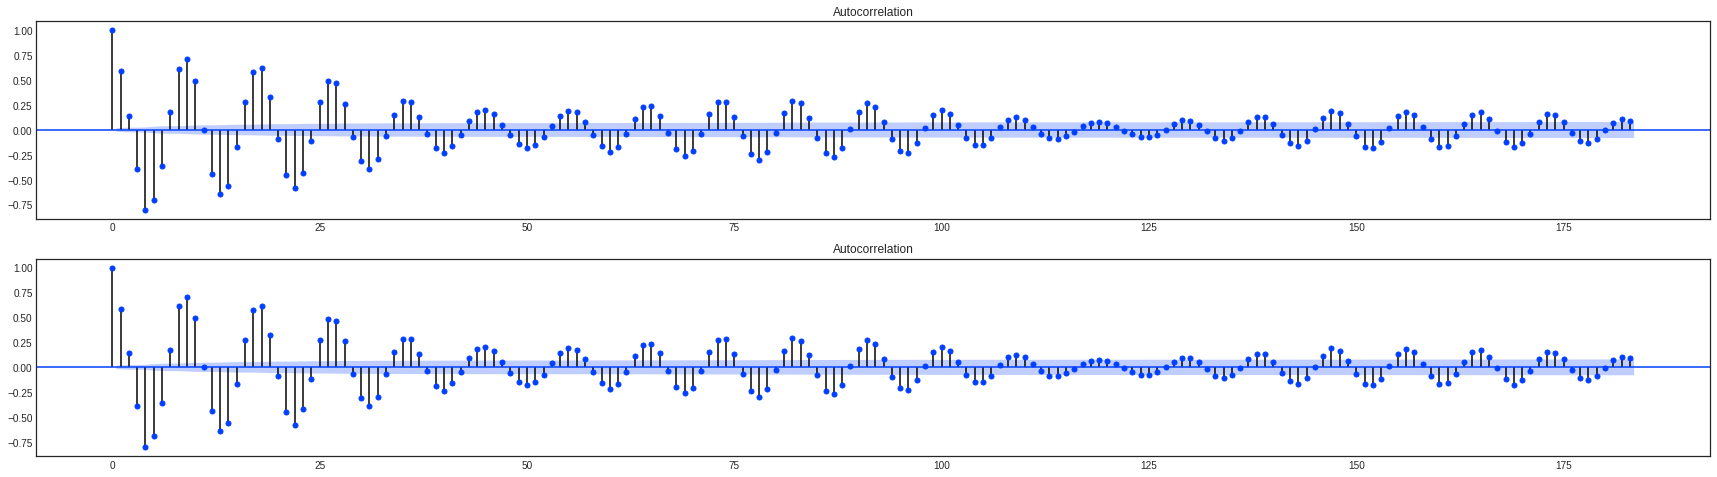

In [ ]:
ig = plt.figure(figsize=(30,8))
ax1 = ig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data[cols[2]].values.squeeze(), lags=N, ax=ax1)
ax2 = ig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(data[cols[3]].values.squeeze(), lags=N, ax=ax2)

# Фильтрация

## гаусс

In [ ]:
filtred_penumbral = gaussian_filter(data[cols[2]], N)

In [ ]:
filtred_umbral = gaussian_filter(data[cols[3]], N)

Text(0.5, 1.0, 'Umbral Magnitude filtered with Gauss')

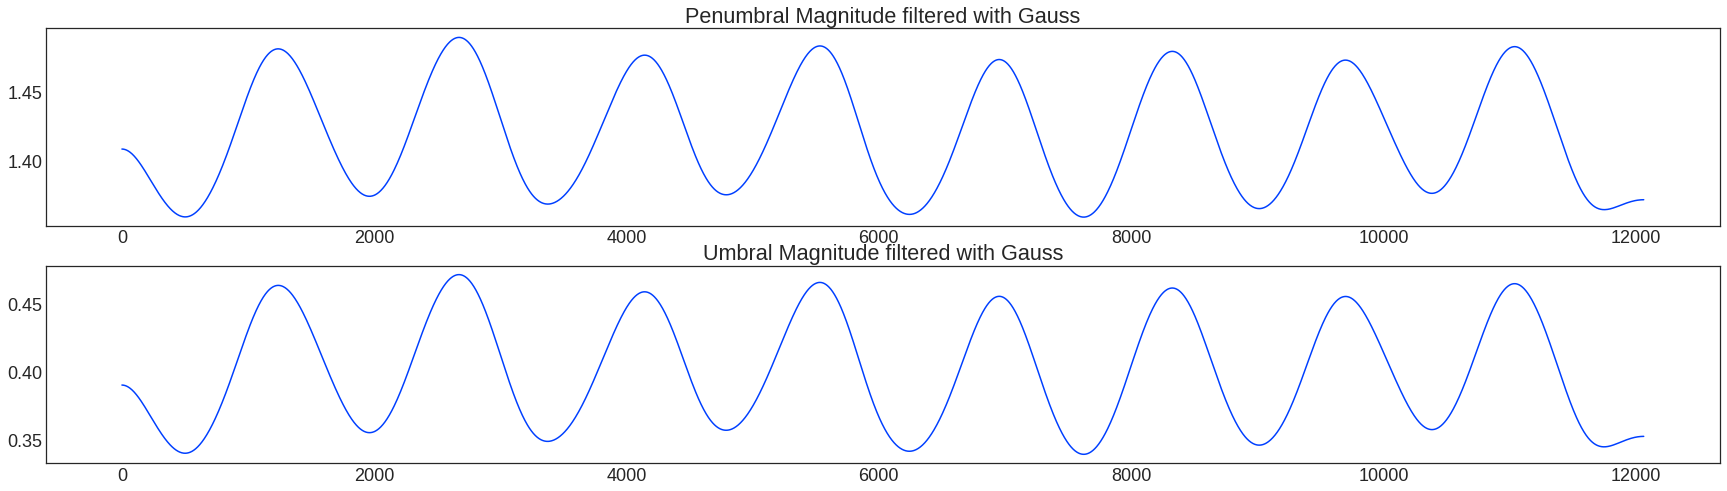

In [ ]:
ig = plt.figure(figsize=(30,8))
ax1 = ig.add_subplot(211)

plt.plot(filtred_penumbral)
ax1.set_title('Penumbral Magnitude filtered with Gauss')
ax2 = ig.add_subplot(212)
plt.plot(filtred_umbral)
ax2.set_title('Umbral Magnitude filtered with Gauss')

In [ ]:
ig = plt.figure(figsize=(30,8))
ax1 = ig.add_subplot(211)
ax1.plot(stattools.acovf(filtred_penumbral, nlag=N))
ax2 = ig.add_subplot(212)
ax2.plot(stattools.acovf(filtred_umbral, nlag=N))

In [ ]:

fig, ax = plt.subplots(2, 1, figsize=(30, 15))
for en, i in enumerate(ax):
    i.plot(stattools.acovf(filtred_penumbral, fft=True, nlag=N))
    i.set_title(cols[en+2])

## скользящее среднее

In [ ]:
penumbral_rm = data[cols[2]].rolling(N).mean().dropna()

In [ ]:
umbral_rm = data[cols[3]].rolling(N).mean().dropna()

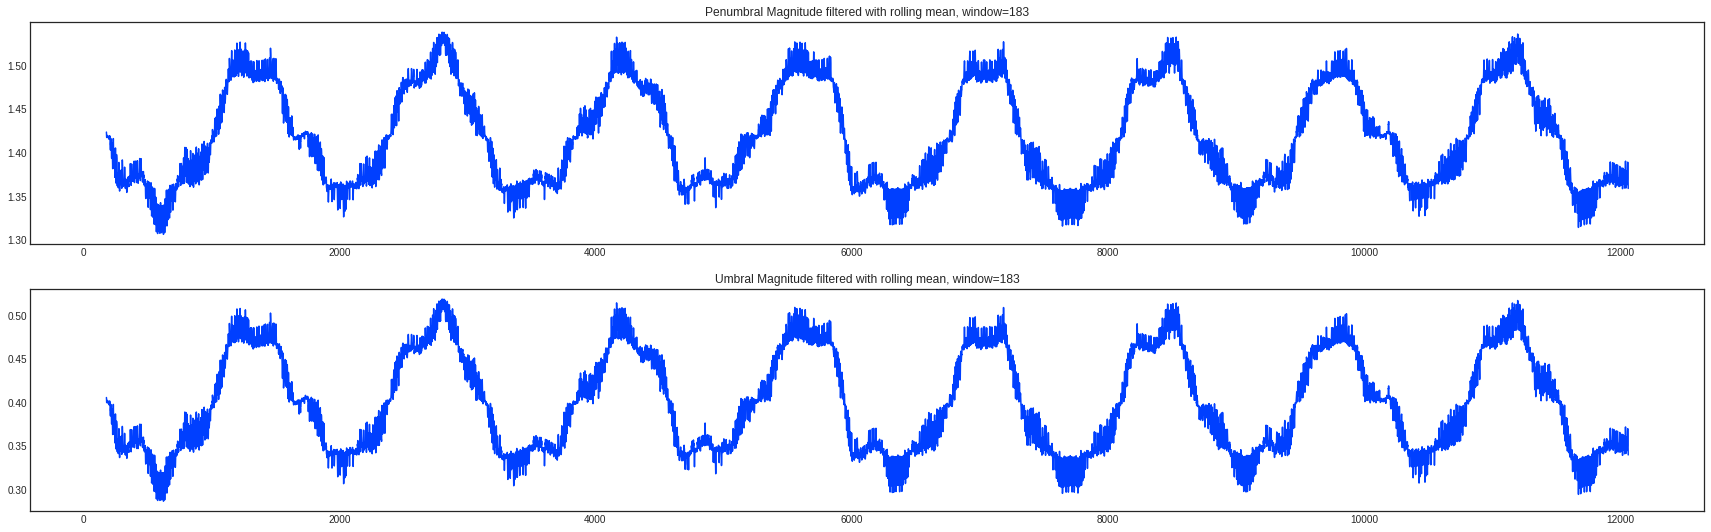

In [ ]:
ig = plt.figure(figsize=(30,9))
ax1 = ig.add_subplot(211)

plt.plot(penumbral_rm)
ax1.set_title('Penumbral Magnitude filtered with rolling mean, window=183')
ax2 = ig.add_subplot(212)
plt.plot(umbral_rm)
ax2.set_title('Umbral Magnitude filtered with rolling mean, window=183');

 # spectral density function

In [ ]:
window_size = 50
blackman = signal.blackman(M=window_size)
bartlett = signal.hanning(M=window_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'penumbral gauss')

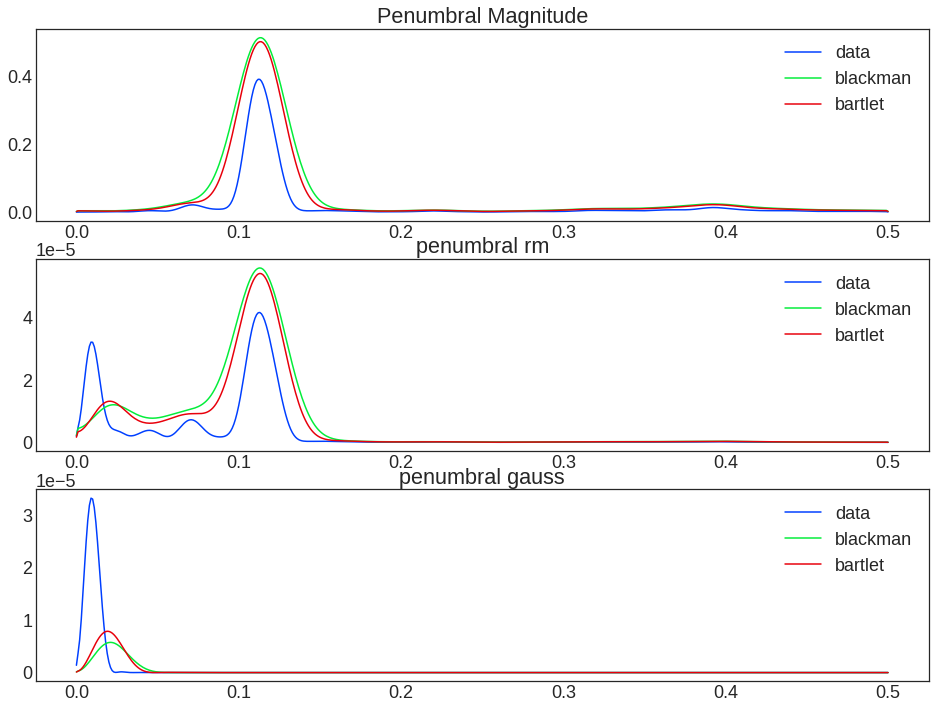

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(16, 12))

f, Pxx_den = signal.welch(data[cols[2]], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
f_window, Pxx_den_window = signal.welch(data[cols[2]], fs=1, window = blackman, nfft = 1000, scaling='spectrum')
f_window_bart, Pxx_den_window_bart = signal.welch(data[cols[2]], fs=1, window = bartlett, nfft = 1000, scaling='spectrum')


ax[0].plot(f, Pxx_den, label='data')
ax[0].plot(f_window, Pxx_den_window, label='blackman')
ax[0].plot(f_window_bart, Pxx_den_window_bart, label='bartlet')
ax[0].legend()
ax[0].set_title(cols[2])

f, Pxx_den = signal.welch(penumbral_rm, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
f_window, Pxx_den_window = signal.welch(penumbral_rm, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
f_window_bart, Pxx_den_window_bart = signal.welch(penumbral_rm, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')

ax[1].plot(f, Pxx_den, label='data')
ax[1].plot(f_window, Pxx_den_window, label='blackman')
ax[1].plot(f_window_bart, Pxx_den_window_bart, label='bartlet')
ax[1].legend()
ax[1].set_title('penumbral rm')

f, Pxx_den = signal.welch(filtred_penumbral, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
f_window, Pxx_den_window = signal.welch(filtred_penumbral, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
f_window_bart, Pxx_den_window_bart = signal.welch(filtred_penumbral, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')

ax[2].plot(f, Pxx_den, label='data')
ax[2].plot(f_window, Pxx_den_window, label='blackman')
ax[2].plot(f_window_bart, Pxx_den_window_bart, label='bartlet')
ax[2].legend()
ax[2].set_title('penumbral gauss')

Text(0.5, 1.0, 'umbral gauss')

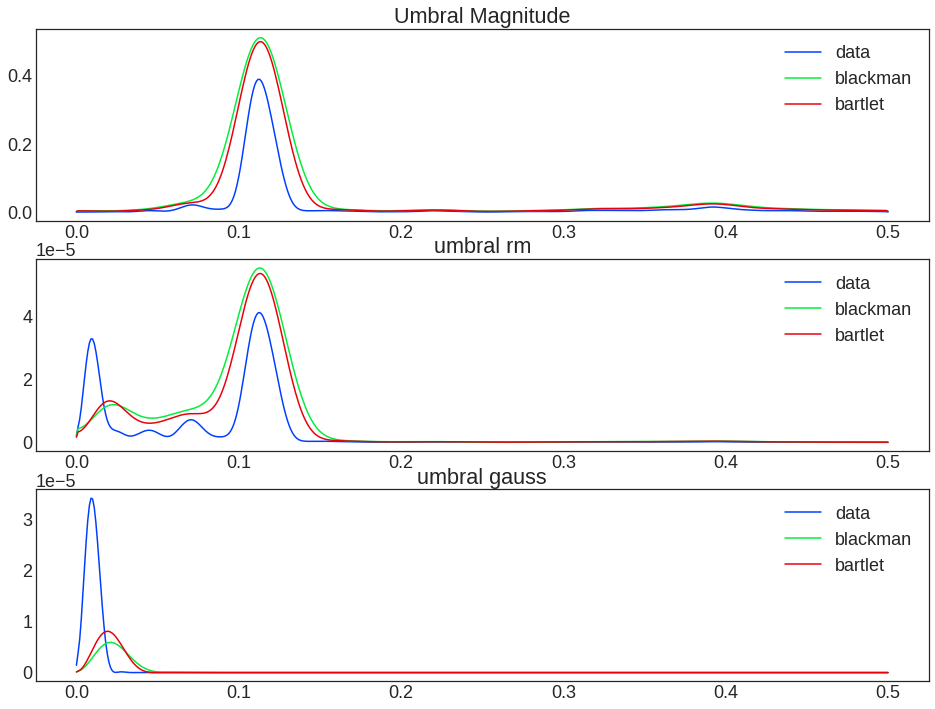

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(16, 12))

f, Pxx_den = signal.welch(data[cols[3]], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
f_window, Pxx_den_window = signal.welch(data[cols[3]], fs=1, window = blackman, nfft = 1000, scaling='spectrum')
f_window_bart, Pxx_den_window_bart = signal.welch(data[cols[3]], fs=1, window = bartlett, nfft = 1000, scaling='spectrum')


ax[0].plot(f, Pxx_den, label='data')
ax[0].plot(f_window, Pxx_den_window, label='blackman')
ax[0].plot(f_window_bart, Pxx_den_window_bart, label='bartlet')
ax[0].legend()
ax[0].set_title(cols[3])

f, Pxx_den = signal.welch(umbral_rm, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
f_window, Pxx_den_window = signal.welch(umbral_rm, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
f_window_bart, Pxx_den_window_bart = signal.welch(umbral_rm, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')

ax[1].plot(f, Pxx_den, label='data')
ax[1].plot(f_window, Pxx_den_window, label='blackman')
ax[1].plot(f_window_bart, Pxx_den_window_bart, label='bartlet')
ax[1].legend()
ax[1].set_title('umbral rm')

f, Pxx_den = signal.welch(filtred_umbral, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
f_window, Pxx_den_window = signal.welch(filtred_umbral, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
f_window_bart, Pxx_den_window_bart = signal.welch(filtred_umbral, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')

ax[2].plot(f, Pxx_den, label='data')
ax[2].plot(f_window, Pxx_den_window, label='blackman')
ax[2].plot(f_window_bart, Pxx_den_window_bart, label='bartlet')
ax[2].legend()
ax[2].set_title('umbral gauss')

# ar model

## penumbral

In [ ]:
model = sm.tsa.ARIMA(data[cols[2]][:-50], order=(3,0,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     Penumbral Magnitude   No. Observations:                12014
Model:                      ARMA(3, 1)   Log Likelihood               -7628.491
Method:                        css-mle   S.D. of innovations              0.457
Date:                 Fri, 26 Nov 2021   AIC                          15268.981
Time:                         15:51:54   BIC                          15313.344
Sample:                              0   HQIC                         15283.862
                                                                               
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.4188      0.002    623.681      0.000       1.414       1.423
ar.L1.Penumbral Magnitude     0.8989      0.009    102.080      0.000       0.882       0.916
ar.L2.Penumbral Magnitude    -0.0762      0.012     -6.344      0.000      -0.100      -0.053
ar.L3.Penumbral Magnitude    -0.5246      0.008    -63.364      0.000      -0.541      -0.508
ma.L1.Penumbral Magnitude    -0.6167      0.007    -88.058      0.000      -0.630      -0.603
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8017           -0.6689j            1.0441           -0.1107
AR.2            0.8017           +0.6689j            1.0441            0.1107
AR.3           -1.7487           -0.0000j            1.7487           -0.5000
MA.1            1.6214           +0.0000j            1.6214            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'residuals')

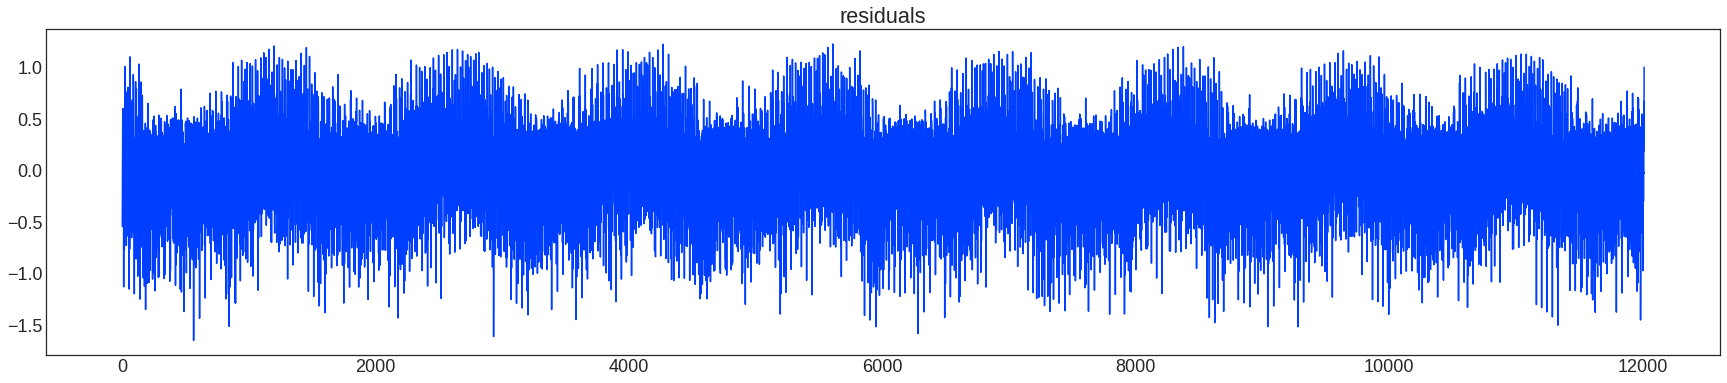

In [ ]:
plt.plot(model.resid)
plt.title('residuals')

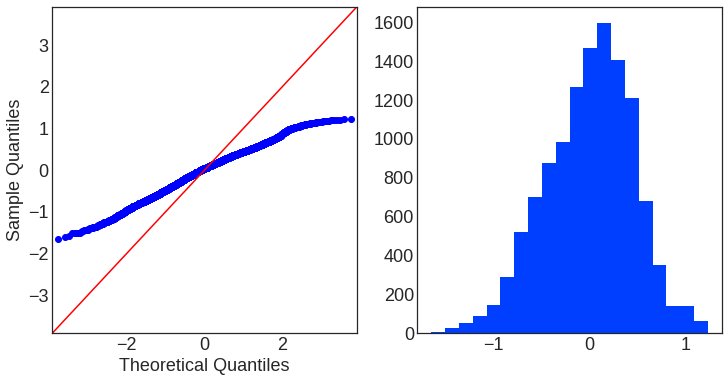

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(model.resid, line='45', ax=ax[0])
ax[1].hist(model.resid, bins=20);

In [ ]:
scipy.stats.shapiro(model.resid)

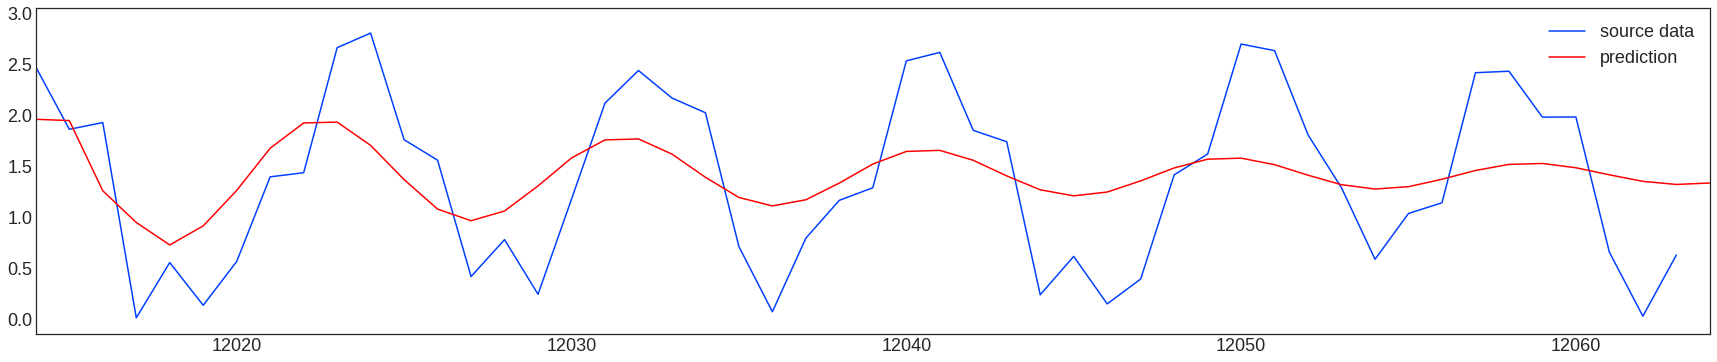

In [ ]:
plt.plot(data[cols[2]],  label='source data')
plt.plot(data[cols[2]][:-50])
plt.plot(model.predict(12014, 12064), 'r', label='prediction')
plt.xlim(12014, 12064)
plt.legend()

### filtred

In [ ]:
model = sm.tsa.ARIMA(filtred_penumbral[:-50], order=(1,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                12013
Model:                 ARIMA(1, 1, 1)   Log Likelihood              148873.164
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sat, 27 Nov 2021   AIC                        -297738.329
Time:                        13:02:06   BIC                        -297708.754
Sample:                             1   HQIC                       -297728.408
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.057e-06   9.86e-05      0.031      0.975      -0.000       0.000
ar.L1.D.y      0.9999   5.66e-05   1.77e+04      0.000       1.000       1.000
ma.L1.D.y      0.3461      0.007     47.467      0.000       0.332       0.360
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0001           +0.0000j            1.0001            0.0000
MA.1           -2.8890           +0.0000j            2.8890            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'residuals')

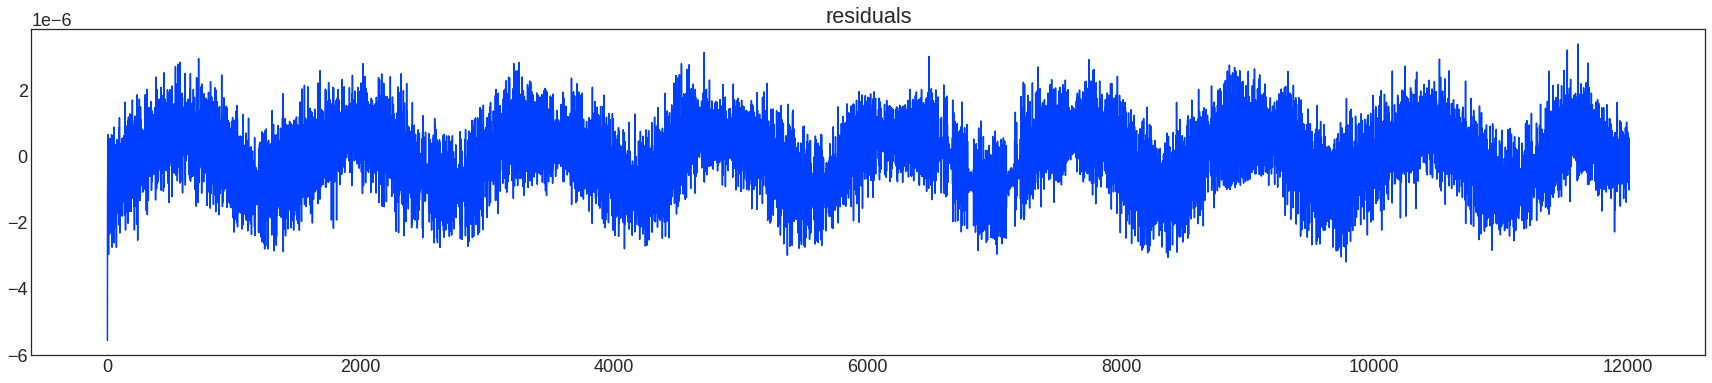

In [ ]:
plt.plot(model.resid)
plt.title('residuals')

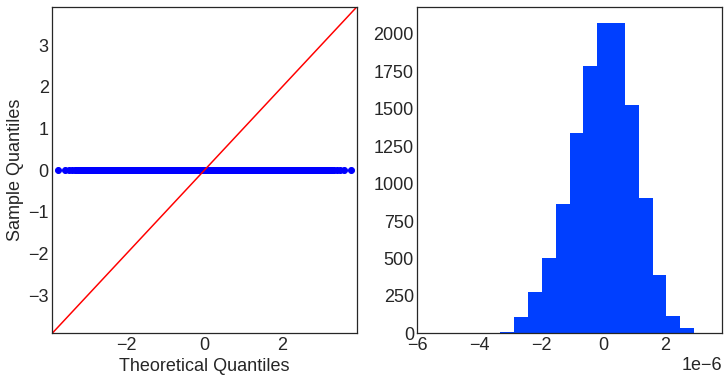

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(model.resid, line='45', ax=ax[0])
ax[1].hist(model.resid, bins=20);

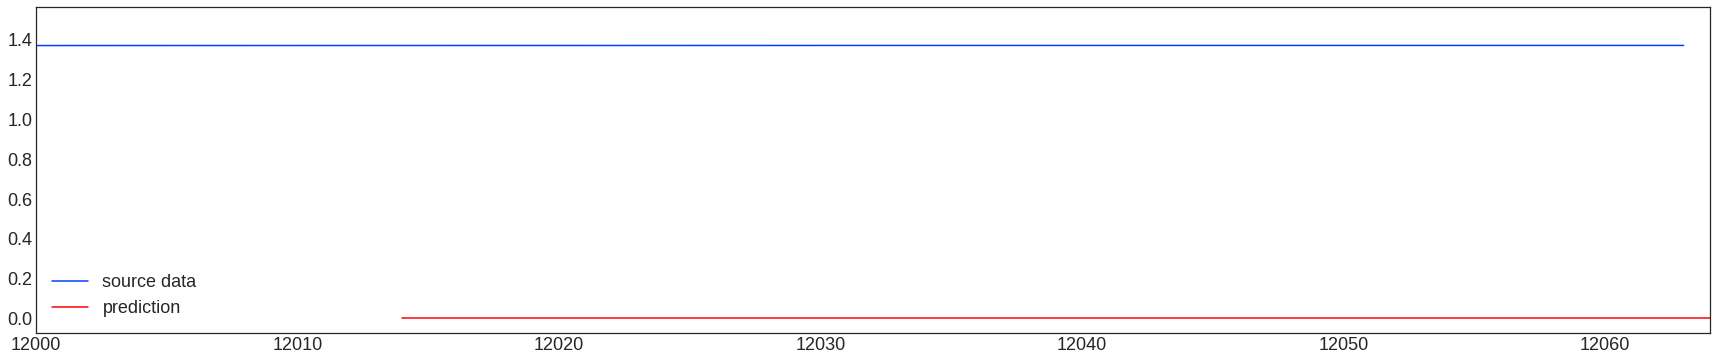

In [ ]:
plt.plot(filtred_penumbral, label='source data')
#plt.plot(filtred_penumbral[:-50])
plt.plot(list(range(12014, 12065)), model.predict(12014, 12064),'r', label='prediction')
plt.xlim(12000, 12064)
plt.legend()

### rm

In [ ]:
model = sm.tsa.ARIMA(penumbral_rm[:-50].values, order=(2,0,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                11832
Model:                     ARMA(2, 0)   Log Likelihood               45978.383
Method:                       css-mle   S.D. of innovations              0.005
Date:                Sat, 27 Nov 2021   AIC                         -91948.765
Time:                        13:43:53   BIC                         -91919.251
Sample:                             0   HQIC                        -91938.858
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4189      0.005    290.144      0.000       1.409       1.428
ar.L1.y        1.5734      0.007    210.630      0.000       1.559       1.588
ar.L2.y       -0.5827      0.007    -78.003      0.000      -0.597      -0.568
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0236           +0.0000j            1.0236            0.0000
AR.2            1.6766           +0.0000j            1.6766            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'residuals')

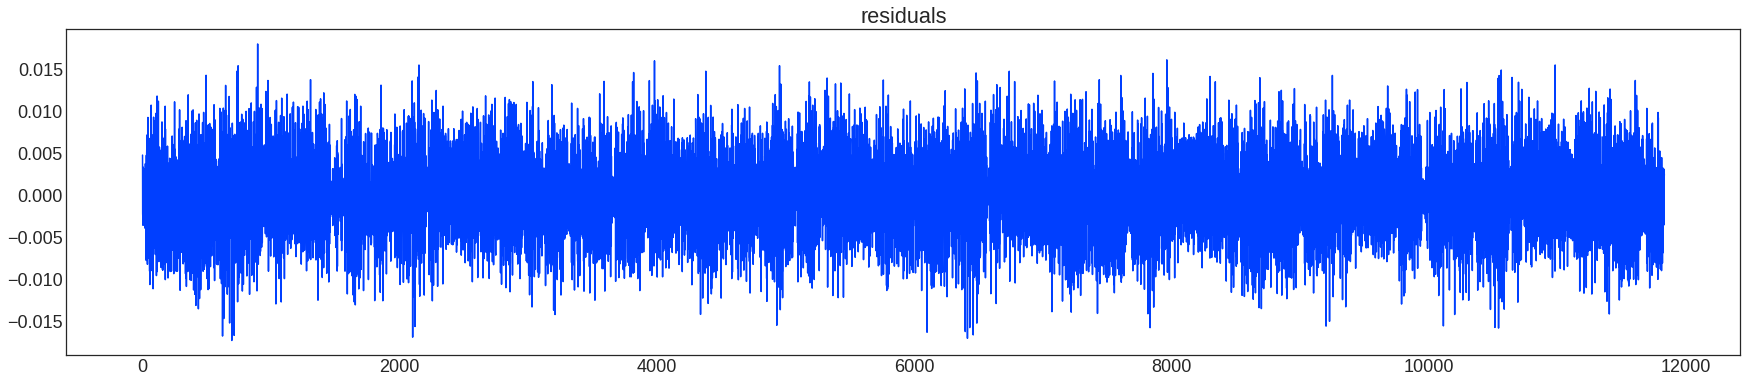

In [ ]:
plt.plot(model.resid)
plt.title('residuals')

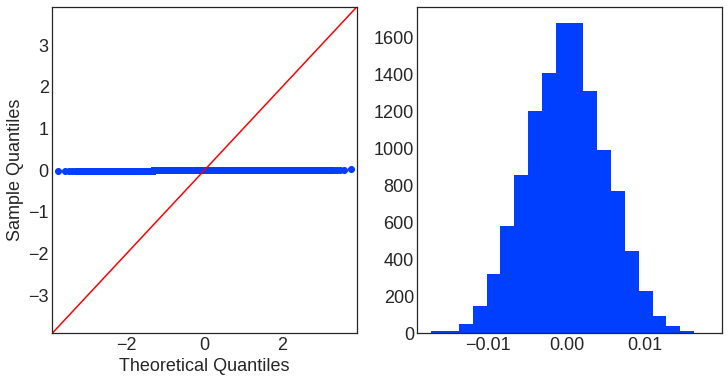

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(model.resid, line='45', ax=ax[0])
ax[1].hist(model.resid, bins=20);

In [ ]:
scipy.stats.shapiro(model.resid)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9989753365516663, 9.187559157908254e-07)

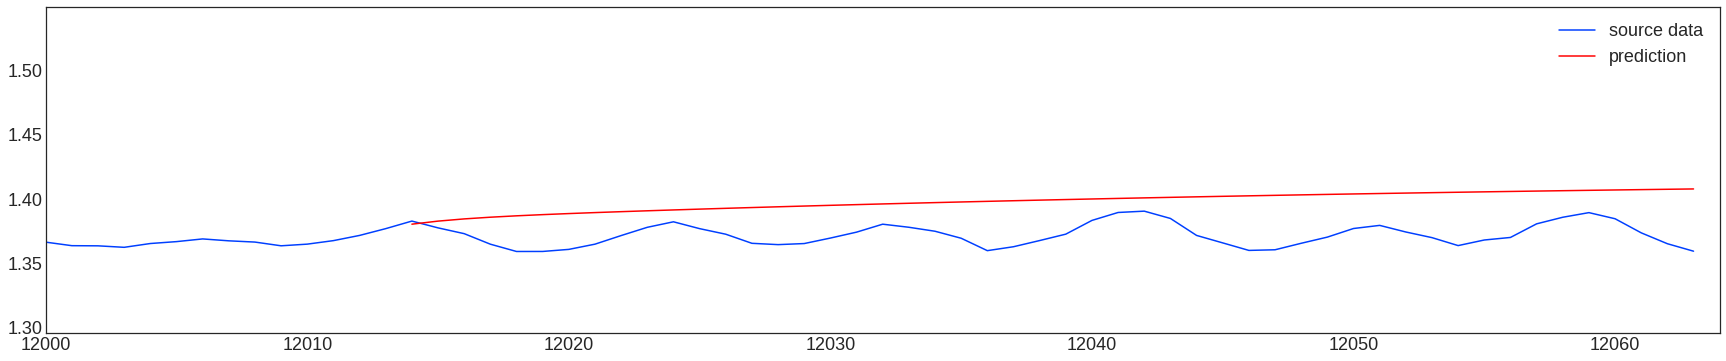

In [ ]:
plt.plot(penumbral_rm, label='source data')
#plt.plot(penumbral_rm[:-50])
plt.plot(list(range(12064-50, 12064)), model.predict(12064-50, 12064)[:50], 'r',label='prediction')
plt.xlim(12000, 12064)
plt.legend()

## umbral

In [ ]:
model = sm.tsa.ARIMA(data[cols[3]][:12064-50], order=(3,0,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       Umbral Magnitude   No. Observations:                12014
Model:                     ARMA(3, 1)   Log Likelihood               -7867.579
Method:                       css-mle   S.D. of innovations              0.466
Date:                Fri, 26 Nov 2021   AIC                          15747.157
Time:                        15:38:44   BIC                          15791.520
Sample:                             0   HQIC                         15762.038
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4003      0.002    175.917      0.000       0.396       0.405
ar.L1.Umbral Magnitude     0.8928      0.009    101.914      0.000       0.876       0.910
ar.L2.Umbral Magnitude    -0.0684      0.012     -5.737      0.000      -0.092      -0.045
ar.L3.Umbral Magnitude    -0.5266      0.008    -63.923      0.000      -0.543      -0.510
ma.L1.Umbral Magnitude    -0.6240      0.007    -90.459      0.000      -0.638      -0.611
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8032           -0.6698j            1.0458           -0.1106
AR.2            0.8032           +0.6698j            1.0458            0.1106
AR.3           -1.7363           -0.0000j            1.7363           -0.5000
MA.1            1.6025           +0.0000j            1.6025            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'residuals')

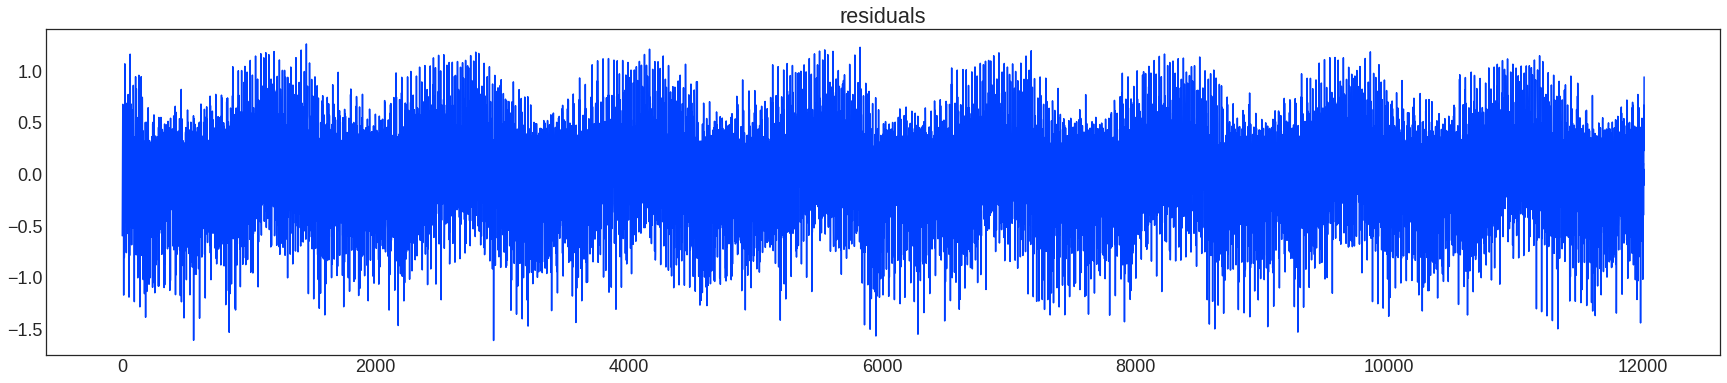

In [ ]:
plt.plot(model.resid)
plt.title('residuals')

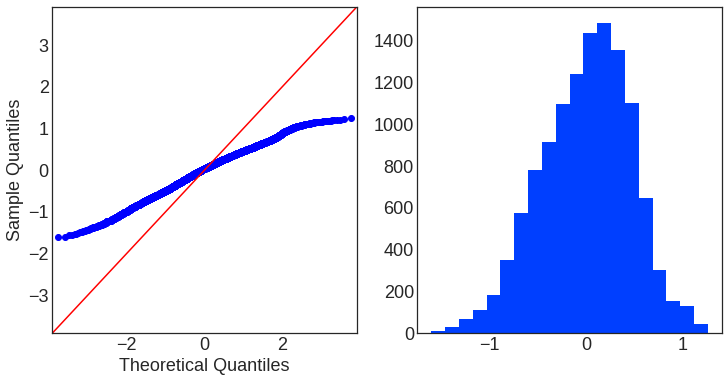

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(model.resid, line='45', ax=ax[0])
ax[1].hist(model.resid, bins=20);

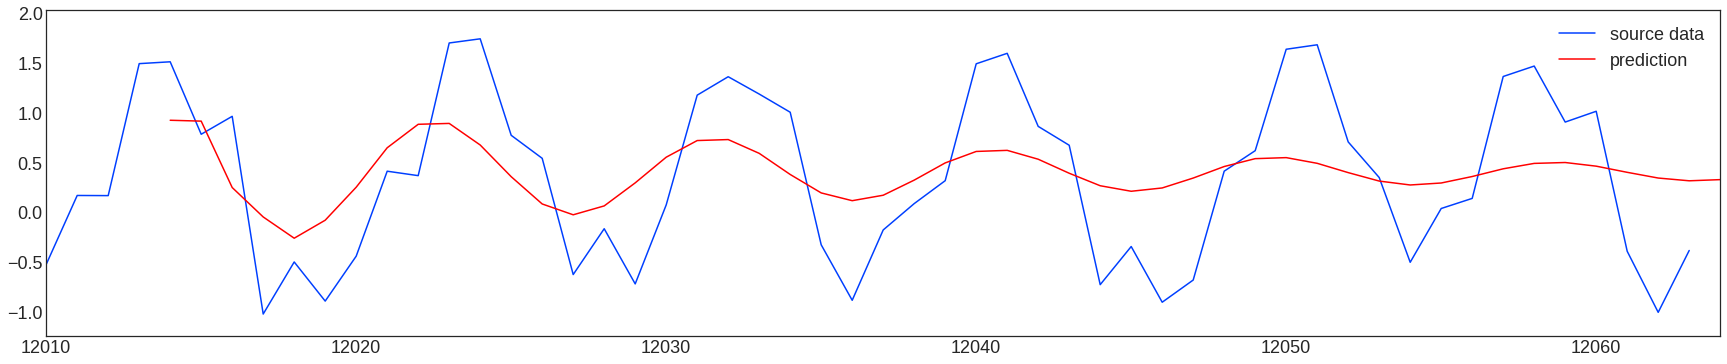

In [ ]:
plt.plot(data[cols[3]], label='source data')
#plt.plot(data[cols[3]][:-1000])
plt.plot(model.predict(12064-50, 12064), 'r', label='prediction')
plt.xlim(12010, 12064)
plt.legend()

### filtered

In [ ]:
model = sm.tsa.ARIMA(filtred_umbral[:12064-50], order=(1,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                12013
Model:                 ARIMA(1, 1, 1)   Log Likelihood              148692.952
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sat, 27 Nov 2021   AIC                        -297377.904
Time:                        13:07:13   BIC                        -297348.329
Sample:                             1   HQIC                       -297367.984
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.342e-06   9.94e-05      0.034      0.973      -0.000       0.000
ar.L1.D.y      0.9999   5.65e-05   1.77e+04      0.000       1.000       1.000
ma.L1.D.y      0.3353      0.007     45.757      0.000       0.321       0.350
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0001           +0.0000j            1.0001            0.0000
MA.1           -2.9820           +0.0000j            2.9820            0.5000
-----------------------------------------------------------------------------
"""

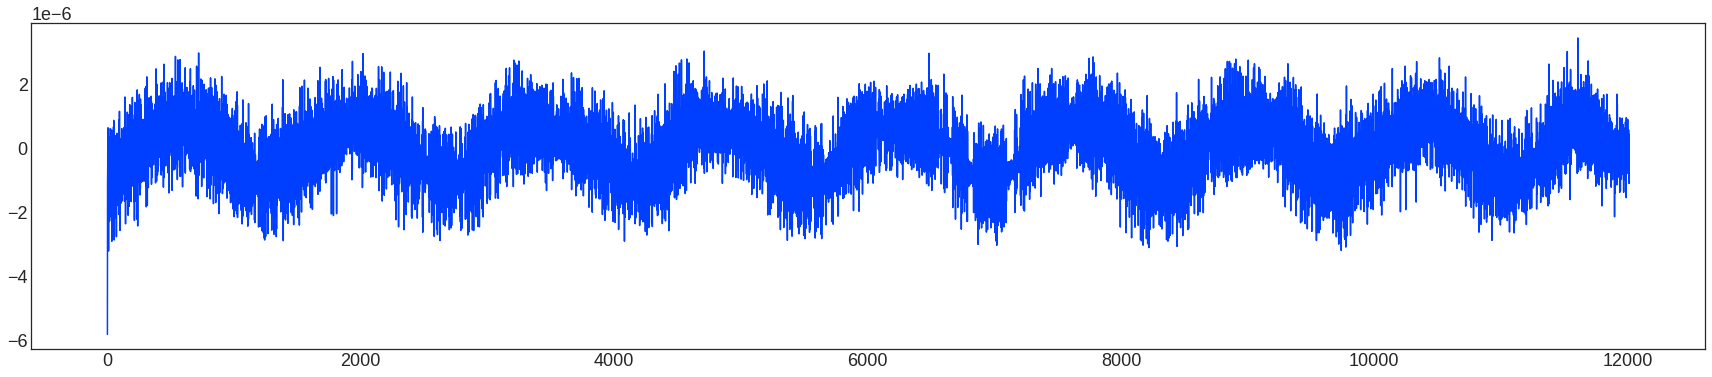

In [ ]:
plt.plot(model.resid)

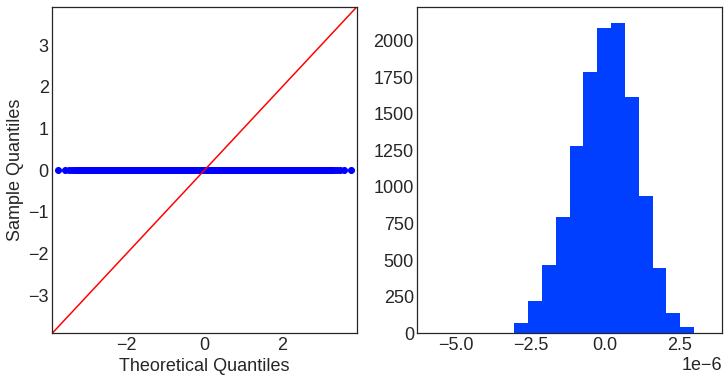

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(model.resid, line='45', ax=ax[0])
ax[1].hist(model.resid, bins=20);

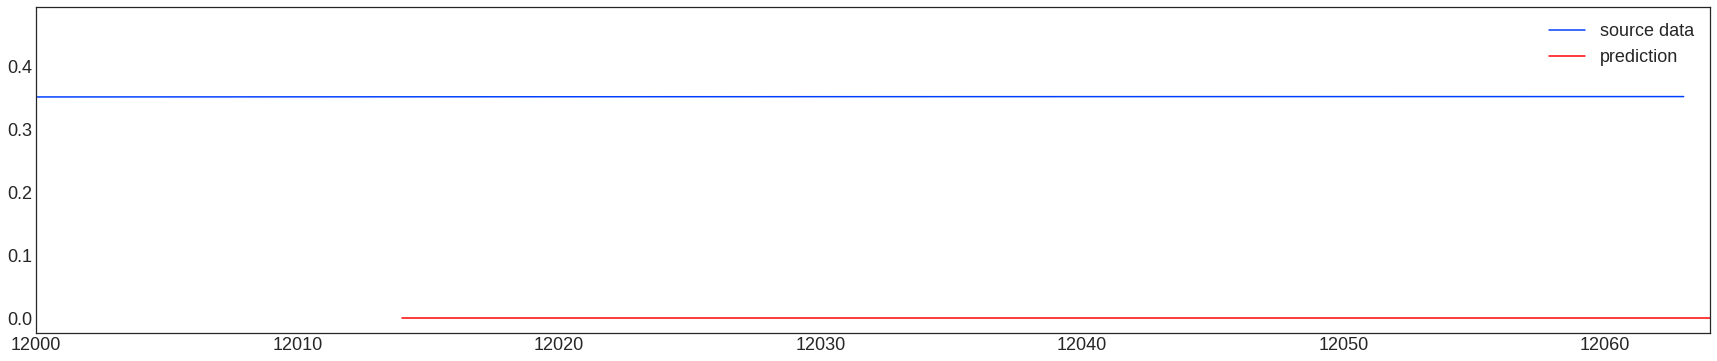

In [ ]:
plt.plot(filtred_umbral, label='source data')

plt.plot(list(range(12064-50, 12065)),model.predict(12064-50, 12064), 'r', label='prediction')
plt.xlim(12000, 12064)
plt.legend()

### rm

In [ ]:
model = sm.tsa.ARIMA(penumbral_rm[:12064-50].values, order=(1,0,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                11882
Model:                     ARMA(1, 0)   Log Likelihood               43710.056
Method:                       css-mle   S.D. of innovations              0.006
Date:                Fri, 26 Nov 2021   AIC                         -87414.112
Time:                        15:48:13   BIC                         -87391.964
Sample:                             0   HQIC                        -87406.679
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4180      0.009    151.368      0.000       1.400       1.436
ar.L1.y        0.9941      0.001   1009.052      0.000       0.992       0.996
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0059           +0.0000j            1.0059            0.0000
-----------------------------------------------------------------------------
"""

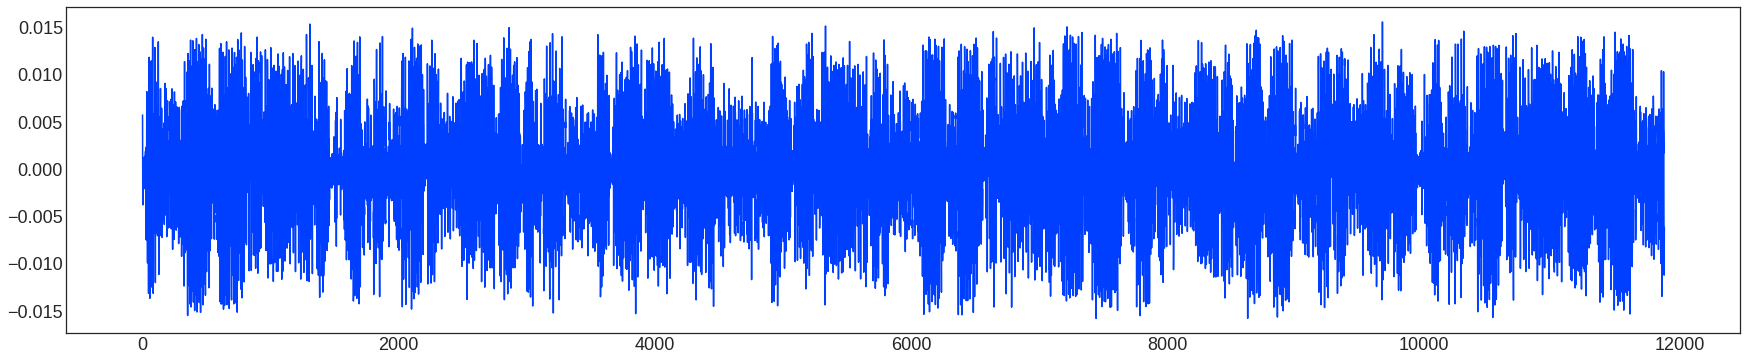

In [ ]:
plt.plot(model.resid)

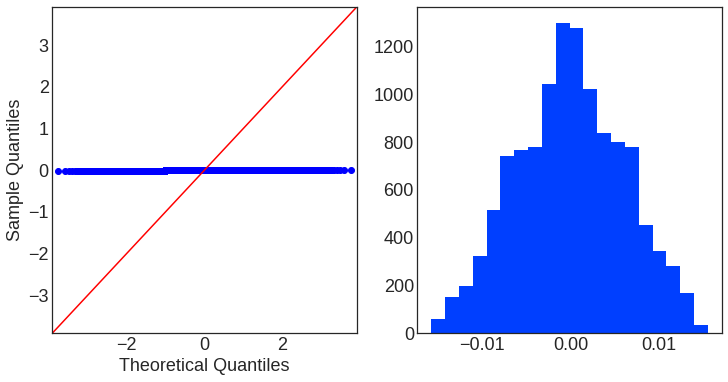

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(model.resid, line='45', ax=ax[0])
ax[1].hist(model.resid, bins=20);

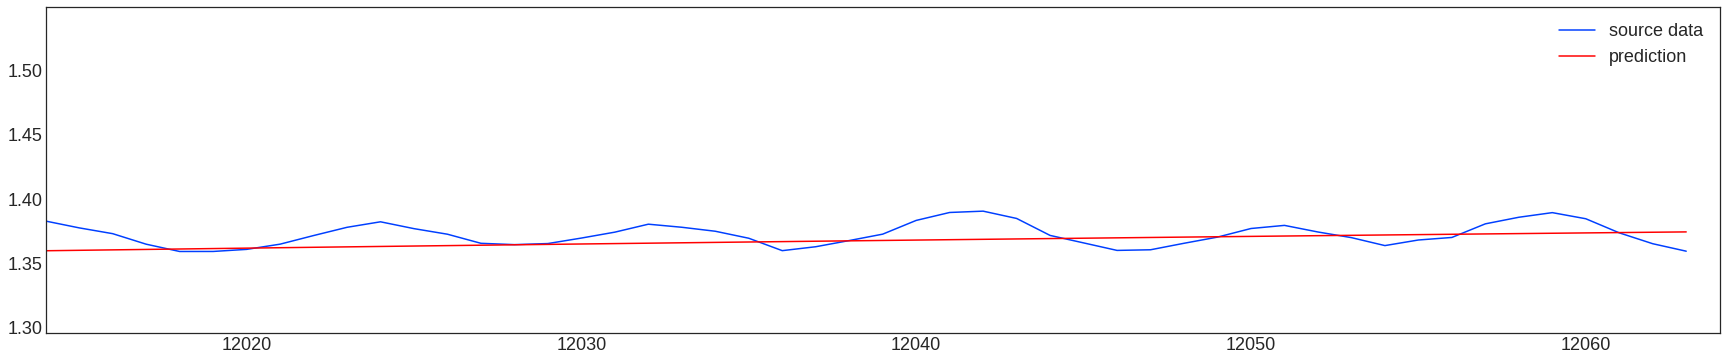

In [ ]:
plt.plot(penumbral_rm,  label='source data')
plt.plot(list(range(12064-50, 12064)), model.predict(12064-50, 12064)[:50], 'r', label='prediction')
plt.xlim(12064-50, 12064)
plt.legend()

# SARIMA

## Penumbral 

In [ ]:
ps = range(0, 3)
d=0
qs = range(0, 2)
Ps = range(0, 3)
D=0
Qs = range(0, 2)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
%%time
from tqdm import tqdm
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data[cols[2]][:12064-50], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 10)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

 31%|███       | 11/36 [00:57<03:38,  8.73s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 83%|████████▎ | 30/36 [05:52<02:01, 20.31s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 92%|█████████▏| 33/36 [06:10<00:34, 11.41s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retval

      parameters           aic
35  (2, 1, 2, 1)  17938.716912
33  (2, 1, 1, 1)  19350.843103
11  (0, 1, 2, 1)  23173.889899
27  (2, 0, 1, 1)  23377.035273
29  (2, 0, 2, 1)  24032.571586
CPU times: user 9min 16s, sys: 6min 18s, total: 15min 35s
Wall time: 8min 11s


In [ ]:
mod = sm.tsa.statespace.SARIMAX(data[cols[2]][:12064-50],
                                order=(2, 0, 1),
                                seasonal_order=(1, 0, 1, 50),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Penumbral Magnitude   No. Observations:                12014
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 50)   Log Likelihood               -9229.097
Date:                            Sat, 04 Dec 2021   AIC                          18470.195
Time:                                    21:13:10   BIC                          18514.532
Sample:                                         0   HQIC                         18485.070
                                          - 12014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3588      0.007    191.451      0.000       1.345       1.373
ar.L2         -0.7791      0.007   -113.253      0.000      -0.793      -0.766
ma.L1         -1.2656      0.012   -104.666      0.000      -1.289      -1.242
ar.S.L50       1.0000   2.51e-05   3.98e+04      0.000       1.000       1.000
ma.S.L50      -0.9979      0.009   -110.409      0.000      -1.016      -0.980
sigma2         0.1669      0.004     39.305      0.000       0.159       0.175
===================================================================================
Ljung-Box (Q):                     6879.11   Jarque-Bera (JB):               141.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'residuals')

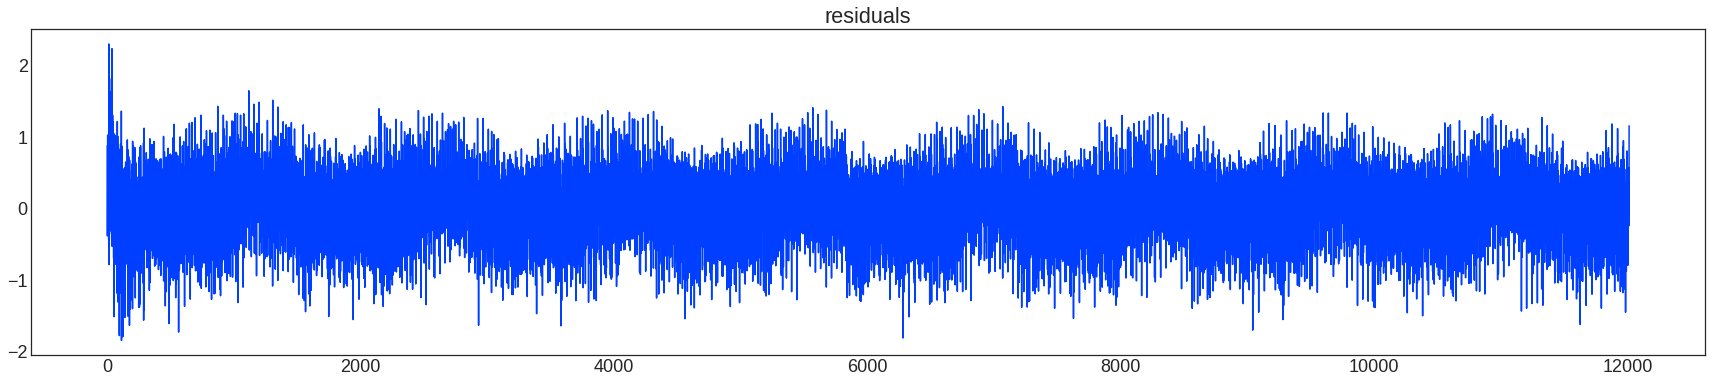

In [ ]:

plt.plot(results.resid)
plt.title('residuals')

In [ ]:
print(format(scipy.stats.shapiro(results.resid)[1], 'f'))

0.000000


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


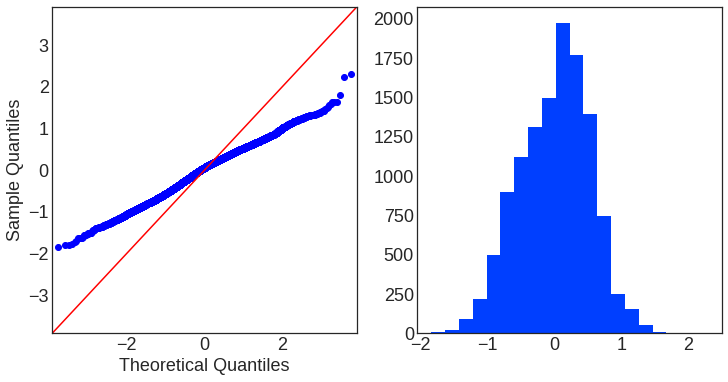

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(results.resid, line='45', ax=ax[0])
ax[1].hist(results.resid, bins=20);

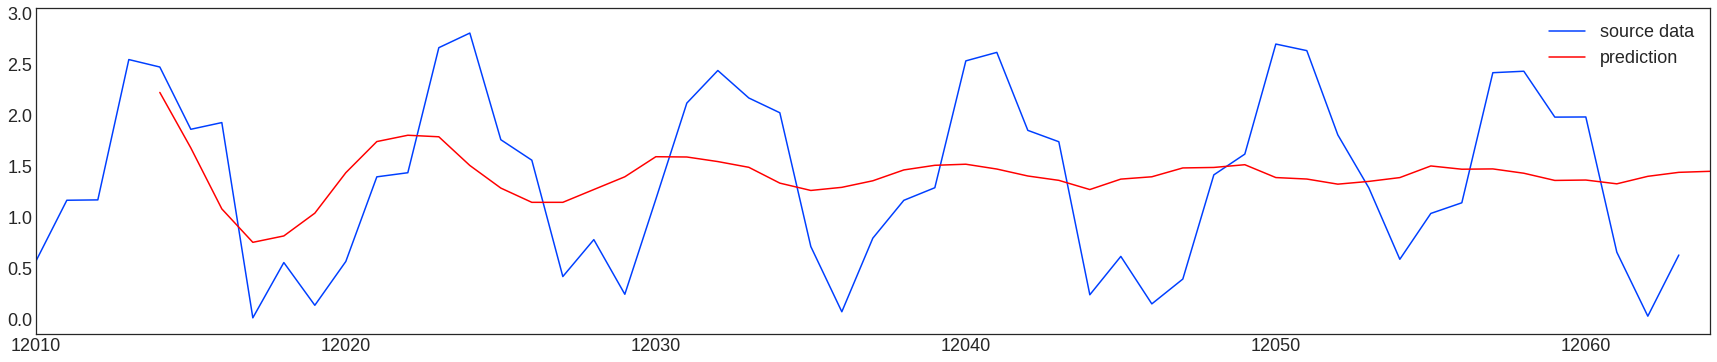

In [ ]:

plt.plot(data[cols[2]], label='source data')
#plt.plot(data[cols[3]][:-1000])
plt.plot(results.predict(12064-50, 12064), 'r', label='prediction')
plt.xlim(12010, 12064)
plt.legend()

### exog 

In [ ]:
%%time
from tqdm import tqdm
results = []
best_aic = float("inf")
exog = sm.add_constant(data[cols[0:1]][:12064-50])
for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data[cols[2]][:12064-50], exog=exog, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 10)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  6%|▌         | 2/36 [00:20<06:11, 10.93s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 11%|█         | 4/36 [01:22<12:52, 24.13s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 19%|█▉        | 7/36 [02:55<12:25, 25.70s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 33%|███▎      | 12/36 [05:56<15:34, 38.96s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 36

      parameters         aic
34  (2, 1, 2, 0) -113.447022
28  (2, 0, 2, 0) -100.555831
31  (2, 1, 0, 1)  -16.820817
35  (2, 1, 2, 1)   44.502425
32  (2, 1, 1, 0)   51.911670
CPU times: user 24min 42s, sys: 16min 32s, total: 41min 14s
Wall time: 23min 40s


In [ ]:
exog = sm.add_constant(data[cols[0:1]][:12064-50])

In [ ]:
mod = sm.tsa.statespace.SARIMAX(data[cols[2]][:12064-50], exog=exog,
                                order=(2, 0, 1),
                                seasonal_order=(1, 0, 0, 50))

results = mod.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Penumbral Magnitude   No. Observations:                12014
Model:             SARIMAX(2, 0, 1)x(1, 0, 0, 50)   Log Likelihood                -144.667
Date:                            Sun, 05 Dec 2021   AIC                            303.333
Time:                                    10:45:00   BIC                            355.090
Sample:                                         0   HQIC                           320.694
                                          - 12014                                         
Covariance Type:                              opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.4586      0.003    162.574      0.000       0.453       0.464
Partial Eclipse Duration (m)     0.0086   2.38e-05    362.297      0.000       0.009       0.009
ar.L1                           -0.2269      0.037     -6.089      0.000      -0.300      -0.154
ar.L2                           -0.2384      0.011    -22.321      0.000      -0.259      -0.217
ma.L1                            0.2505      0.039      6.471      0.000       0.175       0.326
ar.S.L50                         0.0193      0.009      2.030      0.042       0.001       0.038
sigma2                           0.0599      0.001     56.466      0.000       0.058       0.062
===================================================================================
Ljung-Box (Q):                     2741.78   Jarque-Bera (JB):               500.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.42
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'residuals')

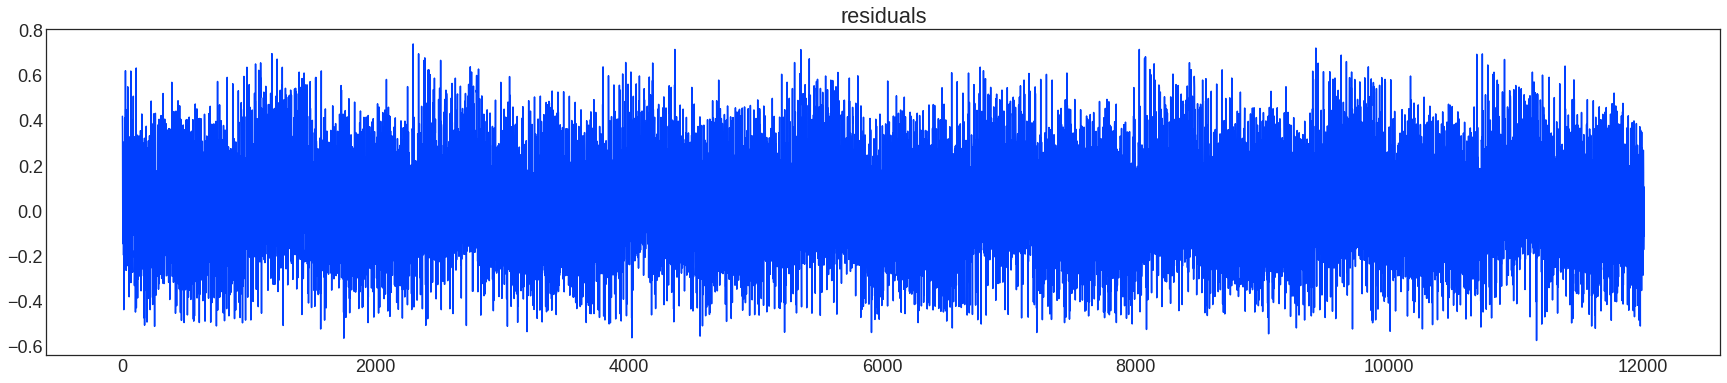

In [ ]:

plt.plot(results.resid)
plt.title('residuals')

In [ ]:
print(format(scipy.stats.shapiro(results.resid)[1], 'f'))

0.000000


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


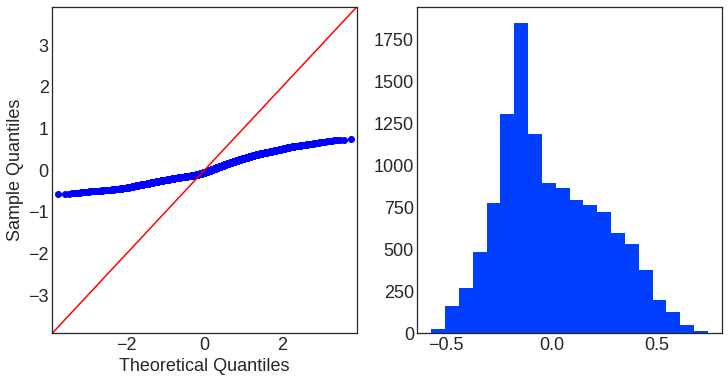

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(results.resid, line='45', ax=ax[0])
ax[1].hist(results.resid, bins=20);

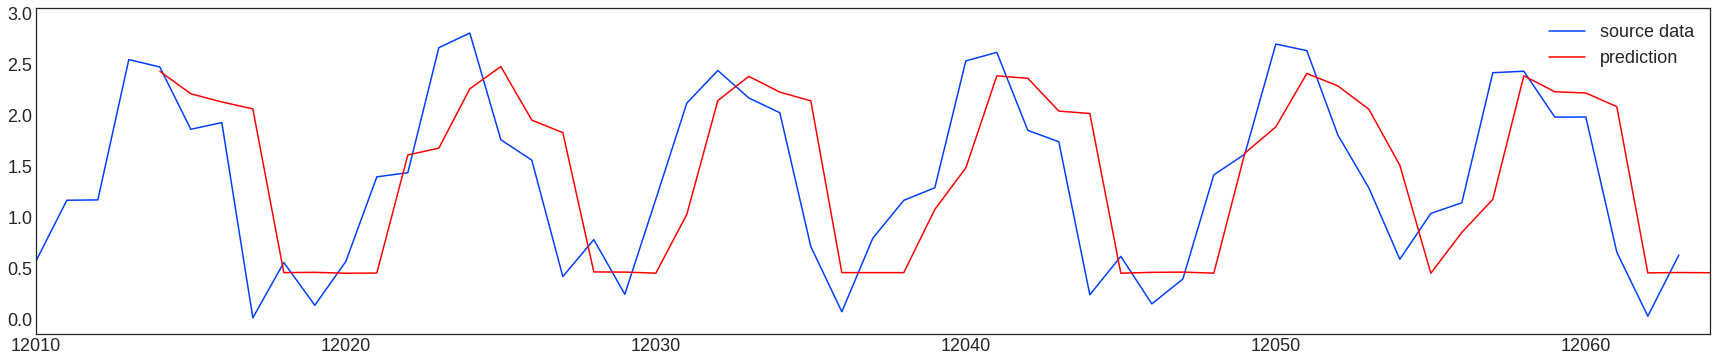

In [ ]:
exog_test = sm.add_constant(data[cols[0:1]][12064-51:])
plt.plot(data[cols[2]], label='source data')
#plt.plot(data[cols[3]][:-1000])

plt.plot(results.predict(12064-50, 12064, exog=exog_test), 'r', label='prediction')
plt.xlim(12010, 12064)
plt.legend()

## umbral

In [ ]:
%%time
from tqdm import tqdm
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data[cols[3]][:12064-50], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 10)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

 83%|████████▎ | 30/36 [02:42<01:05, 10.99s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 92%|█████████▏| 33/36 [03:06<00:28,  9.42s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 36/36 [04:16<00:00,  7.12s/it]

      parameters           aic
33  (2, 1, 1, 1)  18676.326504
32  (2, 1, 1, 0)  21668.385857
31  (2, 1, 0, 1)  22019.372537
35  (2, 1, 2, 1)  22555.676982
29  (2, 0, 2, 1)  22572.978846
CPU times: user 4min 52s, sys: 3min 25s, total: 8min 17s
Wall time: 4min 16s


In [ ]:
mod = sm.tsa.statespace.SARIMAX(data[cols[3]][:12064-50],
                                order=(2, 0, 1),
                                seasonal_order=(1, 0, 1, 50),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                   Umbral Magnitude   No. Observations:                12014
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 50)   Log Likelihood               -9499.751
Date:                            Sat, 04 Dec 2021   AIC                          19011.502
Time:                                    21:04:59   BIC                          19055.839
Sample:                                         0   HQIC                         19026.377
                                          - 12014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3470      0.007    187.074      0.000       1.333       1.361
ar.L2         -0.7625      0.007   -109.157      0.000      -0.776      -0.749
ma.L1         -1.2515      0.011   -109.849      0.000      -1.274      -1.229
ar.S.L50       0.9999   8.64e-05   1.16e+04      0.000       1.000       1.000
ma.S.L50      -0.9993      0.027    -36.415      0.000      -1.053      -0.946
sigma2         0.1761      0.006     28.312      0.000       0.164       0.188
===================================================================================
Ljung-Box (Q):                     7278.96   Jarque-Bera (JB):               164.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.22
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'residuals')

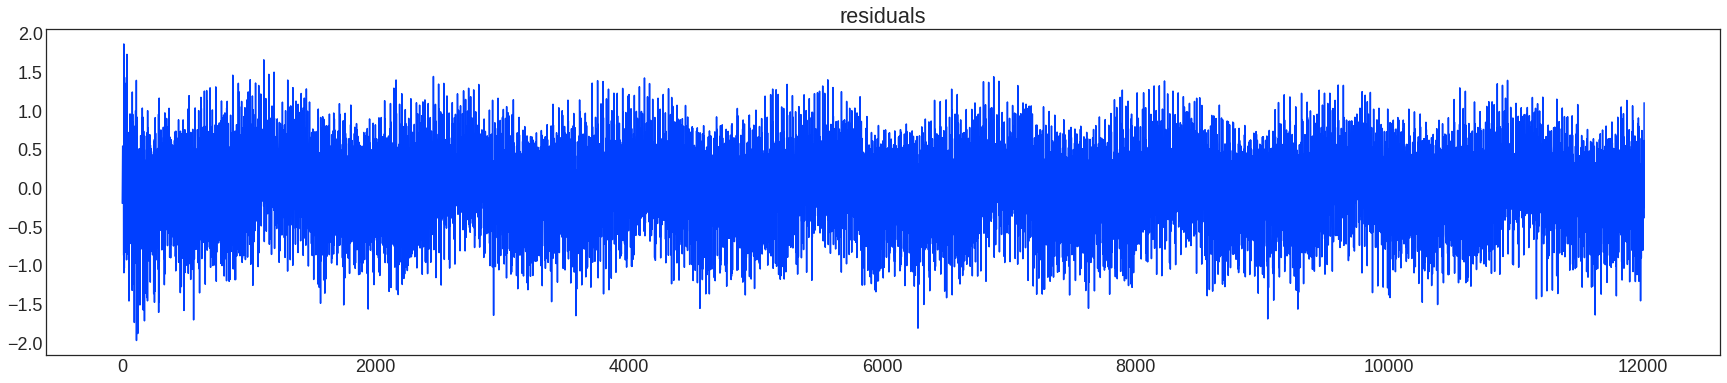

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(results.resid)
plt.title('residuals')

In [ ]:
scipy.stats.shapiro(results.resid)[1]

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


1.4439731260888788e-23

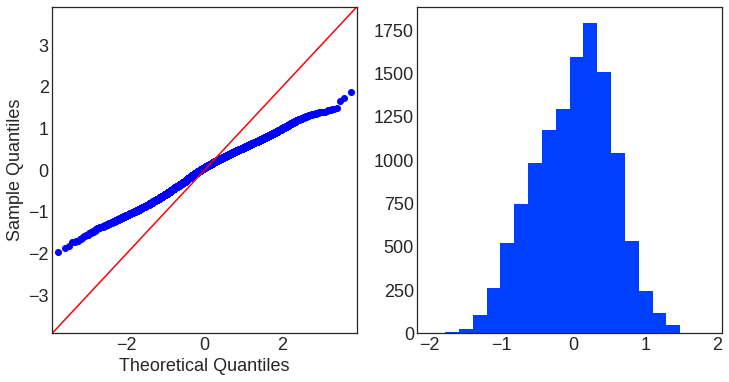

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(results.resid, line='45', ax=ax[0])
ax[1].hist(results.resid, bins=20);

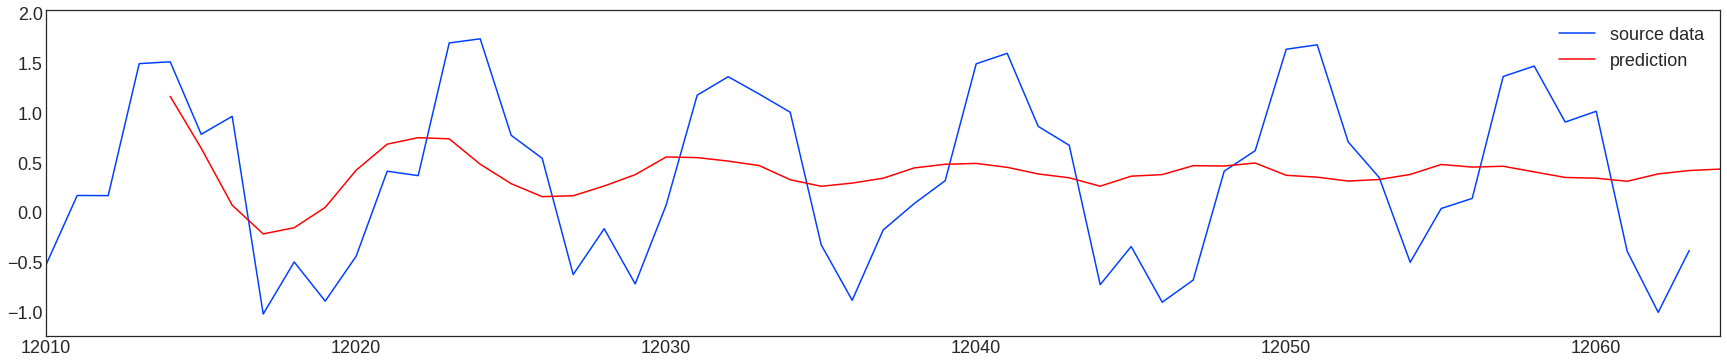

In [ ]:

plt.plot(data[cols[3]], label='source data')
#plt.plot(data[cols[3]][:-1000])
plt.plot(results.predict(12064-50, 12064), 'r', label='prediction')
plt.xlim(12010, 12064)
plt.legend()

### exog

In [ ]:
%%time
from tqdm import tqdm
results = []
best_aic = float("inf")
exog = sm.add_constant(data[cols[0:1]][:12064-50])
for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data[cols[3]][:12064-50], exog=exog, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 10)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  3%|▎         | 1/36 [00:11<06:25, 11.02s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  8%|▊         | 3/36 [00:44<07:37, 13.85s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 11%|█         | 4/36 [01:27<13:33, 25.43s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 17%|█▋        | 6/36 [02:18<12:50, 25.68s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 28%

      parameters         aic
34  (2, 1, 2, 0)  568.432031
28  (2, 0, 2, 0)  575.449648
35  (2, 1, 2, 1)  622.487498
32  (2, 1, 1, 0)  697.645906
31  (2, 1, 0, 1)  698.934427
CPU times: user 22min 32s, sys: 15min 11s, total: 37min 44s
Wall time: 21min 42s


In [ ]:
exog = sm.add_constant(data[cols[0:1]][:12064-50])

In [ ]:
mod = sm.tsa.statespace.SARIMAX(data[cols[3]][:12064-50], exog=exog,
                                order=(2, 0, 1),
                                seasonal_order=(2, 0, 0, 10))

results = mod.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                   Umbral Magnitude   No. Observations:                12014
Model:             SARIMAX(2, 0, 1)x(2, 0, 0, 10)   Log Likelihood                -276.216
Date:                            Sun, 05 Dec 2021   AIC                            568.432
Time:                                    11:51:27   BIC                            627.583
Sample:                                         0   HQIC                           588.273
                                          - 12014                                         
Covariance Type:                              opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.5519      0.003   -191.669      0.000      -0.558      -0.546
Partial Eclipse Duration (m)     0.0086   2.51e-05    341.999      0.000       0.009       0.009
ar.L1                           -0.1396      0.040     -3.479      0.001      -0.218      -0.061
ar.L2                           -0.2260      0.010    -22.453      0.000      -0.246      -0.206
ma.L1                            0.1429      0.041      3.495      0.000       0.063       0.223
ar.S.L10                         0.1551      0.010     16.228      0.000       0.136       0.174
ar.S.L20                        -0.1477      0.009    -15.680      0.000      -0.166      -0.129
sigma2                           0.0603      0.001     60.359      0.000       0.058       0.062
===================================================================================
Ljung-Box (Q):                     2269.53   Jarque-Bera (JB):               351.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.32
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'residuals')

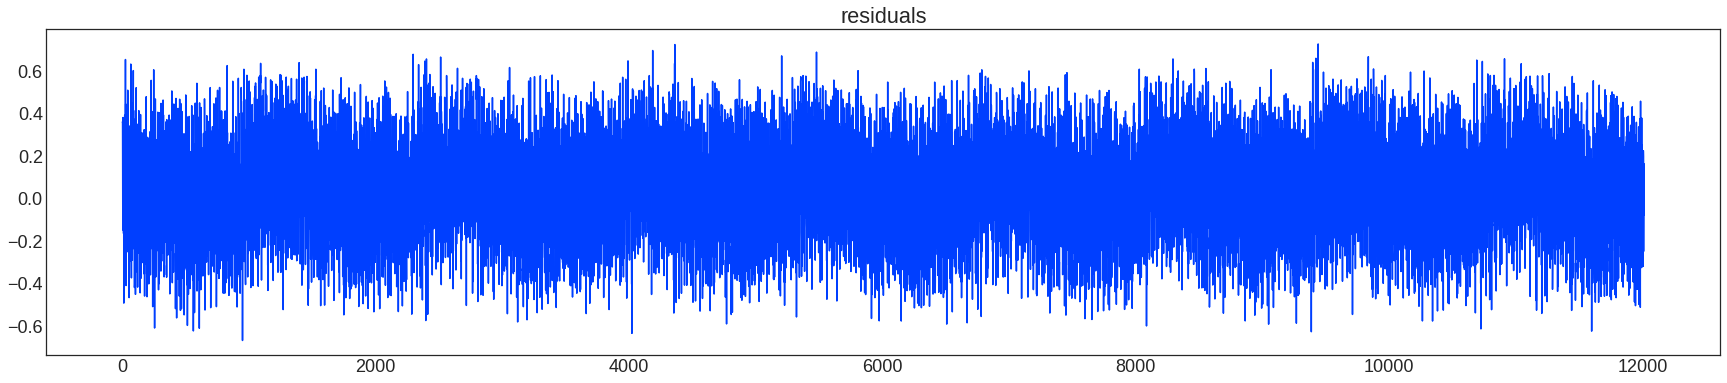

In [ ]:

plt.plot(results.resid)
plt.title('residuals')

In [ ]:
print(format(scipy.stats.shapiro(results.resid)[1], 'f'))

0.000000


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


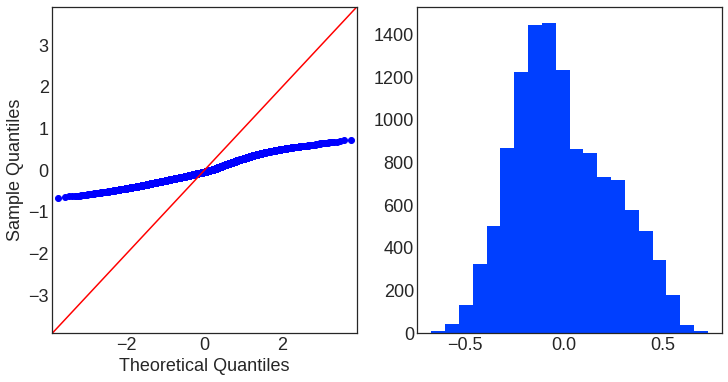

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(results.resid, line='45', ax=ax[0])
ax[1].hist(results.resid, bins=20);

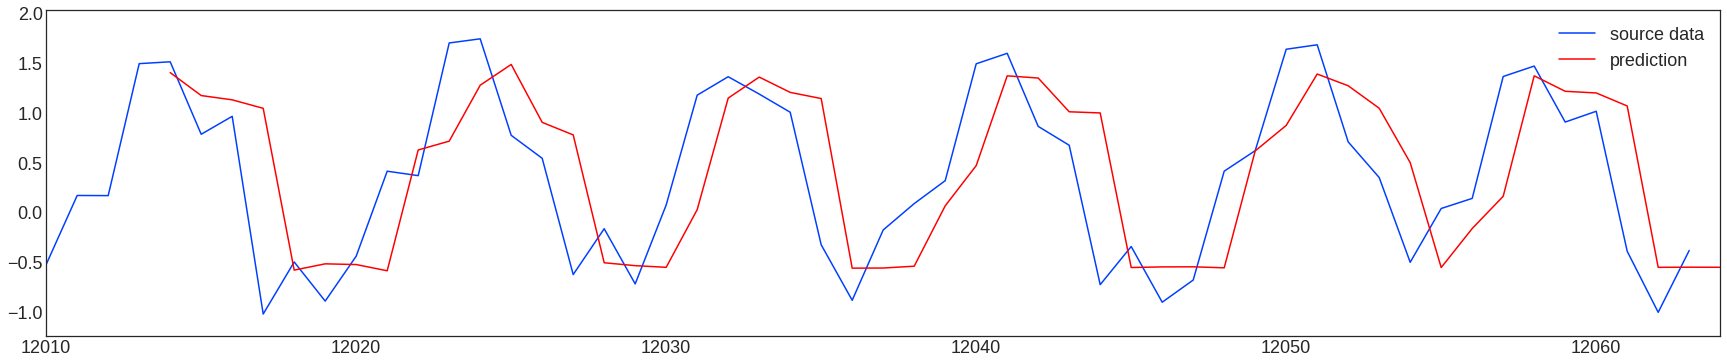

In [ ]:
exog_test = sm.add_constant(data[cols[0:1]][12064-51:])
plt.plot(data[cols[3]], label='source data')
#plt.plot(data[cols[3]][:-1000])

plt.plot(results.predict(12064-50, 12064, exog=exog_test), 'r', label='prediction')
plt.xlim(12010, 12064)
plt.legend()

# linear dynamical model

## penumbral

In [ ]:
from fedot.core.data.data_split import train_test_data_setup
def wrap_into_input(forecast_length, feature_time_series, target_time_series):
    """ Convert data for FEDOT framework """
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(target_time_series)),
                           features=feature_time_series, target=target_time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data

forecast_length = 50

ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=data[cols[2]].values,
                       target_time_series=data[cols[2]].values)

train_ts, test_ts = train_test_data_setup(ts_1)

In [ ]:
ts_2 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=data[cols[0]].values,
                       target_time_series=data[cols[2]].values)

ts_3 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=data[cols[1]].values,
                       target_time_series=data[cols[2]].values)
dataset = MultiModalData({
    'data_source_ts/2': ts_1,
    'data_source_ts/1': ts_3,
    'data_source_ts/0': ts_2
})

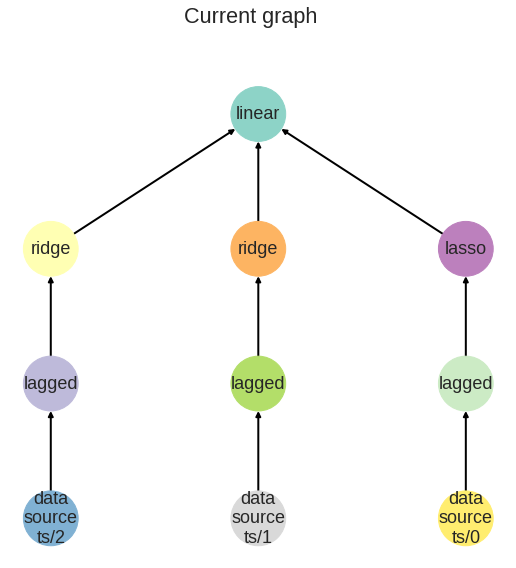

In [ ]:
train, test = train_test_data_setup(dataset)

def create_multisource_pipeline():
    """ Generate pipeline with several data sources """
    node_source_1 = PrimaryNode('data_source_ts/2')
    node_source_11 = PrimaryNode('data_source_ts/1')
    node_source_2 = PrimaryNode('data_source_ts/0')

    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_source_1])
    node_lagged_1.custom_params = {'window_size': 150}
    node_lagged_11 = SecondaryNode('lagged', nodes_from=[node_source_11])
    node_lagged_2 = SecondaryNode('lagged', nodes_from=[node_source_2])
      
    node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_ridge1 = SecondaryNode('ridge', nodes_from=[node_lagged_11])
    node_lasso = SecondaryNode('lasso', nodes_from=[node_lagged_2])
    
    node_final = SecondaryNode('linear', nodes_from=[node_ridge, node_ridge1, node_lasso])
    pipeline = Pipeline(node_final)
    return pipeline

pipeline = create_multisource_pipeline()
pipeline.show()

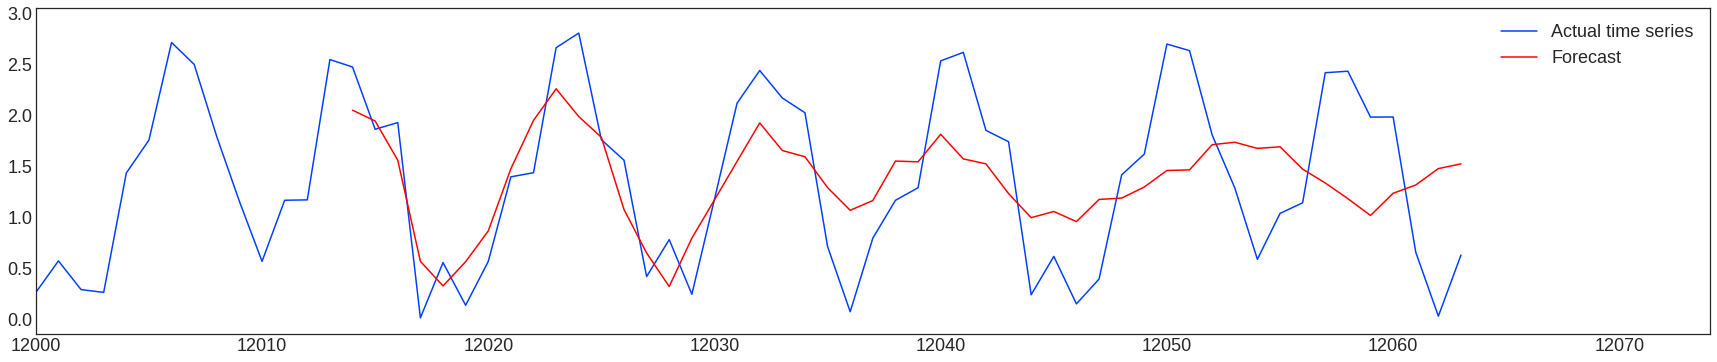

In [ ]:
pipeline.fit(train)
forecast = pipeline.predict(test)

train_length = len(data[cols[2]]) - forecast_length

plt.plot(data[cols[2]], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
         np.ravel(forecast.predict), 'r', label='Forecast')
plt.xlim(12000, len(data[cols[2]]) + 10)
plt.legend()
plt.show()

In [ ]:
r2_score(data[cols[2]][12064-50:], np.ravel(forecast.predict))

0.38534078173803776

Text(0.5, 1.0, 'residuals')

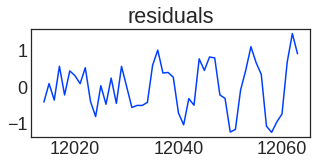

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(np.ravel(forecast.predict) - data[cols[2]][12064-50:])
plt.title('residuals')

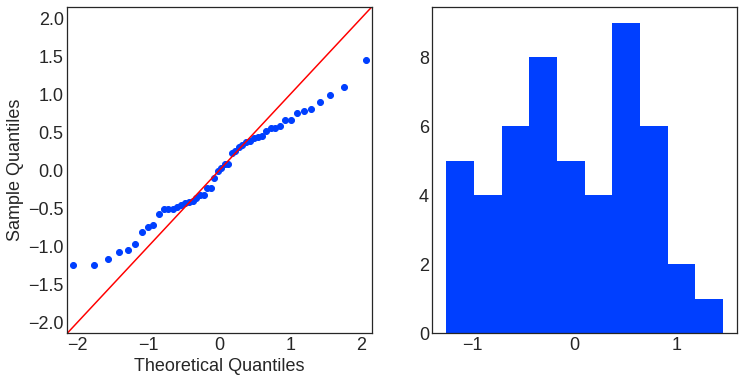

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(np.ravel(forecast.predict) - data[cols[2]][12064-50:], line='45', ax=ax[0])
ax[1].hist(np.ravel(forecast.predict) - data[cols[2]][12064-50:], bins=10);

## umbral

In [ ]:
forecast_length = 50

ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=data[cols[3]].values,
                       target_time_series=data[cols[3]].values)

train_ts, test_ts = train_test_data_setup(ts_1)

In [ ]:
ts_2 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=data[cols[0]].values,
                       target_time_series=data[cols[3]].values)

ts_3 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=data[cols[1]].values,
                       target_time_series=data[cols[3]].values)
dataset = MultiModalData({
    'data_source_ts/2': ts_1,
    'data_source_ts/1': ts_3,
    'data_source_ts/0': ts_2
})

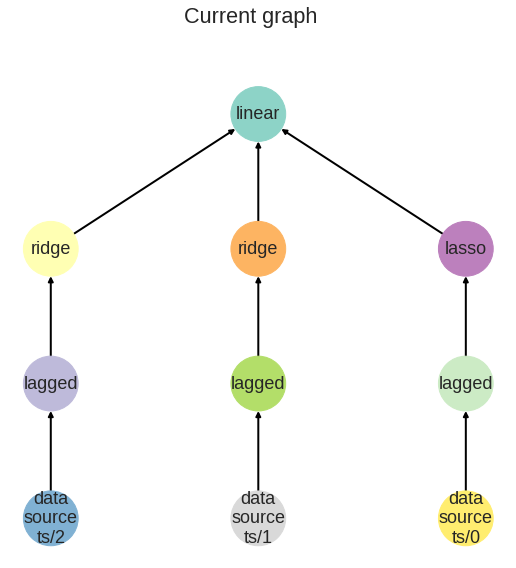

In [ ]:
train, test = train_test_data_setup(dataset)

def create_multisource_pipeline():
    """ Generate pipeline with several data sources """
    node_source_1 = PrimaryNode('data_source_ts/2')
    node_source_11 = PrimaryNode('data_source_ts/1')
    node_source_2 = PrimaryNode('data_source_ts/0')

    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_source_1])
    node_lagged_1.custom_params = {'window_size': 150}
    node_lagged_11 = SecondaryNode('lagged', nodes_from=[node_source_11])
    node_lagged_2 = SecondaryNode('lagged', nodes_from=[node_source_2])
      
    node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_ridge1 = SecondaryNode('ridge', nodes_from=[node_lagged_11])
    node_lasso = SecondaryNode('lasso', nodes_from=[node_lagged_2])
    
    node_final = SecondaryNode('linear', nodes_from=[node_ridge, node_ridge1, node_lasso])
    pipeline = Pipeline(node_final)
    return pipeline

pipeline = create_multisource_pipeline()
pipeline.show()

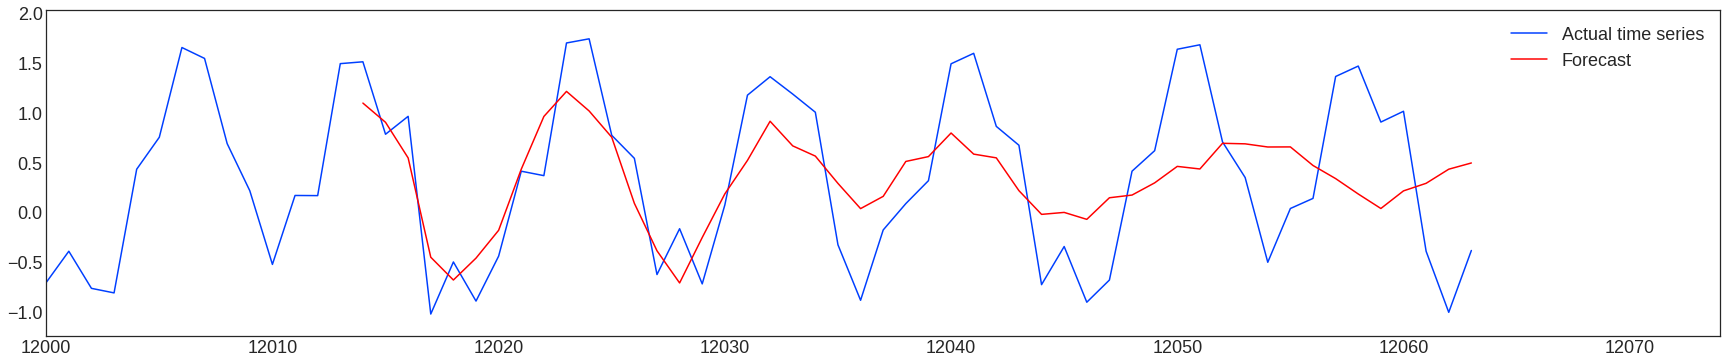

In [ ]:
pipeline.fit(train)
forecast = pipeline.predict(test)

train_length = len(data[cols[3]]) - forecast_length

plt.plot(data[cols[3]], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
         np.ravel(forecast.predict), 'r', label='Forecast')
plt.xlim(12000, len(data[cols[3]]) + 10)
plt.legend()
plt.show()

In [ ]:
r2_score(data[cols[3]][12064-50:], np.ravel(forecast.predict))

0.39778922730727495

Text(0.5, 1.0, 'residuals')

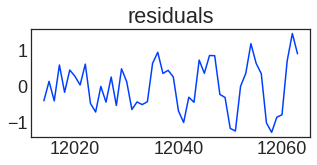

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(np.ravel(forecast.predict) - data[cols[3]][12064-50:])
plt.title('residuals')

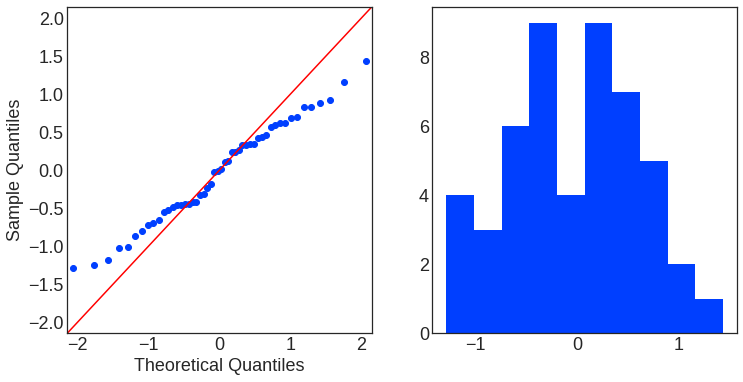

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = qqplot(np.ravel(forecast.predict) - data[cols[3]][12064-50:], line='45', ax=ax[0])
ax[1].hist(np.ravel(forecast.predict) - data[cols[3]][12064-50:], bins=10);